## Explainability of Attention Mechanisms in `t2` with Z Features. Add to L.

This notebook looks at the attention responses for a given input and tries to explore the explainability of the attention mechanism that is being used in the `t2` model

In [101]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.ticker as ticker

from matplotlib import rcParams
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from astronet.constants import astronet_working_directory as asnwd
from astronet.t2.model import T2Model
from astronet.utils import astronet_logger, load_dataset, find_optimal_batch_size
from astronet.visualise_results import (
    plot_acc_history,
    plot_confusion_matrix,
    plot_loss_history,
    plot_multiROC,
    _get_encoding,
)

tf.get_logger().setLevel('ERROR')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

plt.rcParams["figure.figsize"] = (20,3)
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=28)
mpl.rc('ytick', labelsize=28)


print(plt.style.available)

mpl.style.use("seaborn-whitegrid")

architecture = "t2"

dataset = "plasticc"

snonly = None

if snonly is not None:
    dataform = "snonly"
else:
    dataform = "full"

# X_train, y_train, X_test, y_test, loss, Z_train, Z_test = load_dataset(
#     dataset, redshift=True, snonly=snonly, testset=None,
# )

X_test = np.load(
        f"{asnwd}/data/plasticc/test_set/infer/X_test.npy",
)
y_test = np.load(
        f"{asnwd}/data/plasticc/test_set/infer/y_test.npy",
)
Z_test = np.load(
        f"{asnwd}/data/plasticc/test_set/infer/Z_test.npy",
)

num_classes = y_test.shape[1]
print(num_classes)

BATCH_SIZE = find_optimal_batch_size(X_test.shape[0])
_, timesteps, num_features = X_test.shape  # X_train.shape[1:] == (TIMESTEPS, num_features)
input_shape = (BATCH_SIZE, timesteps, num_features)
print(input_shape)

_, num_z_features = Z_test.shape
Z_input_shape = (BATCH_SIZE, num_z_features)

model_name = "1619624444-0.1.dev765+g7c90cbb.d20210428"

with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results_with_z.json") as f:
    events = json.load(f)
    if model_name is not None:
    # Get params for model chosen with cli args
        event = next(item for item in events['training_result'] if item["name"] == model_name)
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["augmented"] is None),
                key=lambda ev: ev["model_evaluate_on_test_loss"],
            )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

model_name = event['name']

embed_dim = event['embed_dim']  # --> Embedding size for each token
num_heads = event['num_heads']  # --> Number of attention heads
ff_dim = event['ff_dim']  # --> Hidden layer size in feed forward network inside transformer

# --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
num_filters = embed_dim

num_layers = event['num_layers']    # --> N x repeated transformer blocks
droprate = event['droprate']        # --> Rate of neurons to drop

input_shape_nobatch = input_shape[1:]
Z_input_shape_nobatch = Z_input_shape[1:]

inputs = [
    tf.keras.Input(shape=input_shape_nobatch),
    tf.keras.Input(shape=Z_input_shape_nobatch),
]

# input_shape_nobatch = input_shape[1:]
# inputs = tf.keras.Input(shape=input_shape_nobatch)

print(input_shape_nobatch, Z_input_shape_nobatch)
print(input_shape)

print(inputs)

tf.config.run_functions_eagerly(True)

model = T2Model(
    input_dim=input_shape,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_filters=num_filters,
    num_classes=num_classes,
    num_layers=num_layers,
    droprate=droprate,
    num_aux_feats=2,
    add_aux_feats_to="L",
)

model.call(inputs, training=True)
model.build(input_shape)
print(model.summary())

model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}")

print(model.layers)

for i in model.layers:
    print(i.output)

encoding, class_encoding, class_names = _get_encoding(dataset, dataform=dataform)
class_mapping = {
    90: "SNIa",
    67: "SNIa-91bg",
    52: "SNIax",
    42: "SNII",
    62: "SNIbc",
    95: "SLSN-I",
    15: "TDE",
    64: "KN",
    88: "AGN",
    92: "RRL",
    65: "M-dwarf",
    16: "EB",
    53: "Mira",
    6: "$\mu$-Lens-Single",
}
class_encoding
class_names = list(np.vectorize(class_mapping.get)(class_encoding))
print(class_names)

for i in range(len(model.layers)):
    print(i, model.layers[i].name)

from keras.models import Model
# same as previous model but with an additional output
cam_model = Model(inputs=inputs,outputs=(model.layers[2].output,model.layers[5].output), name="CAM")
print(cam_model.summary())

# get the features and results of the test images using the newly created model
features,results = cam_model.predict([X_test, Z_test])

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

print(features.shape)

# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:]

print(f"The features for image index {idx} has shape (timesteps, num of feature channels) : ", features_for_img.shape)

# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img, gap_weights_for_one_class)
print("class activation map shape ", cam.shape)

cam_all = np.dot(features, gap_weights)
print("all class activation map shape ", cam_all.shape)

# from scipy.special import softmax
np.set_printoptions(precision=15)
pd.options.display.float_format = '{:.15f}'.format

from sklearn.preprocessing import minmax_scale, normalize

(num_objects, num_cam_features, num_classes) = cam_all.shape

df = pd.DataFrame(data=cam_all.reshape((num_objects * num_classes), num_cam_features))
data = pd.DataFrame(columns=df.columns)

for i in range(num_classes):

    mm = minmax_scale(cam_all[:, :, i], feature_range=(0,1), axis=1)
    norm = normalize(mm, norm='l1')
    ddf = pd.DataFrame(data=norm)
    ddf["class"] = class_names[i]

    data = pd.concat([data, ddf])

assert data.shape == ((num_objects * num_classes), (num_cam_features + 1))  # Plus one for the added class column

# print(cam_all.max())
# print(cam_all.min())
# print(cam_all.shape)

# import numpy.testing as npt
# npt.assert_almost_equal((cam_all.shape[0] * cam_all.shape[2]), cam_all_softmax.sum(), decimal=1)
# npt.assert_almost_equal((num_objects * num_classes), data.sum(axis=1).sum(), decimal=1)

# camr = cam_all_softmax[:,100:102,:]
# camr = cam_all_softmax[:,:,:]

# df = pd.DataFrame(data=camr.reshape(27468,2), columns=["redshift", "redshift_error"])
# df = pd.DataFrame(data=cam_all.reshape((num_objects * num_classes), num_cam_features))

# data = pd.DataFrame(columns=df.columns)
# for i, chunk in enumerate(np.array_split(df, 14)):
#     # Creates new column here
#     chunk["class"] = class_names[i]
#     assert len(chunk) == len(df) / 14
#     data = pd.concat([data, chunk])

# assert data.shape == ((num_objects * num_classes), (num_cam_features + 1))  # Plus one for the added class column

for i, chunk in enumerate(np.array_split(data, 1)):
    print(chunk.shape)
    # Column 'class' already exists at this point, so no new column created.
    chunk["class"] = "All Classes"
    data_all = pd.concat([data, chunk])

# data = data.rename(columns={100: "redshift", 101: "redshift-error"})
data_all.rename(
    columns={100: "redshift", 101: "redshift-error"}, inplace=True
)
# data_all = data_all.rename(columns={100: "redshift", 101: "redshift-error"})

dfz = data_all.filter(
    items=[
        "redshift",
        "redshift-error",
        "class",
    ]
)
assert "All Classes" in dfz["class"].unique()

dfza = dfz[dfz["class"] == "All Classes"]
assert len(dfza) == (num_objects * num_classes)

print(f"DFZA SHAPE:{dfza.shape}")

redshift_mean = dfza["redshift"].mean() * 100
print(f"REDSHIFT MEAN: {redshift_mean}")
redshift_error_mean = dfza["redshift-error"].mean() * 100
print(f"REDSHIFT-ERROR MEAN: {redshift_error_mean}")

# figure size in inches
rcParams["figure.figsize"] = 16, 9
rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})
sns.set_theme(style="whitegrid")

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
14
(256, 100, 6)
(100, 6) (2,)
(256, 100, 6)
[<KerasTensor: shape=(None, 100, 6) dtype=float32 (created by layer 'input_3')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_4')>]
Model: "t2_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_embedding_1 (ConvEmbedd (None, 102, 32)           224       
_________________________________________________________________
positional_encoding_1 (Posit (None, 102, 32)           0         
_______

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


KeyboardInterrupt: 

In [235]:
######################################################################################
def make_violin(dfza):
    mpl.style.use("seaborn-whitegrid")
    rcParams["figure.figsize"] = 16, 9
    ax = sns.violinplot(data=dfza, palette=plt.cm.seismic(np.linspace(0, 1, 2)), inner=None)
#     sns.violinplot(x=df["species"], y=df["sepal_length"], color="skyblue", inner=None)
    sns.boxenplot(data=dfza, palette="Set2", width=0.075)

    ax.set_title(r'Activation Weight Distriubtion ', fontsize=28)
    ax.set_xlabel('All Classes', fontsize=28)
    ax.set_xticklabels([r"Redshift", r"Redshift Error"], fontsize=18)
    ax.set_ylabel('Activation Weight Percentage', fontsize=28)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
    ax.set(ylim=(0, 0.025))
    ax.tick_params(labelsize=18)
    fig = ax.get_figure()
    plt.savefig(
        f"{asnwd}/astronet/t2/plots/plasticc/cams/cam-violin-all-classes.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()
    plt.clf()

In [236]:
plt.cm.seismic(np.linspace(0, 1, 2))

array([[0. , 0. , 0.3, 1. ],
       [0.5, 0. , 0. , 1. ]])

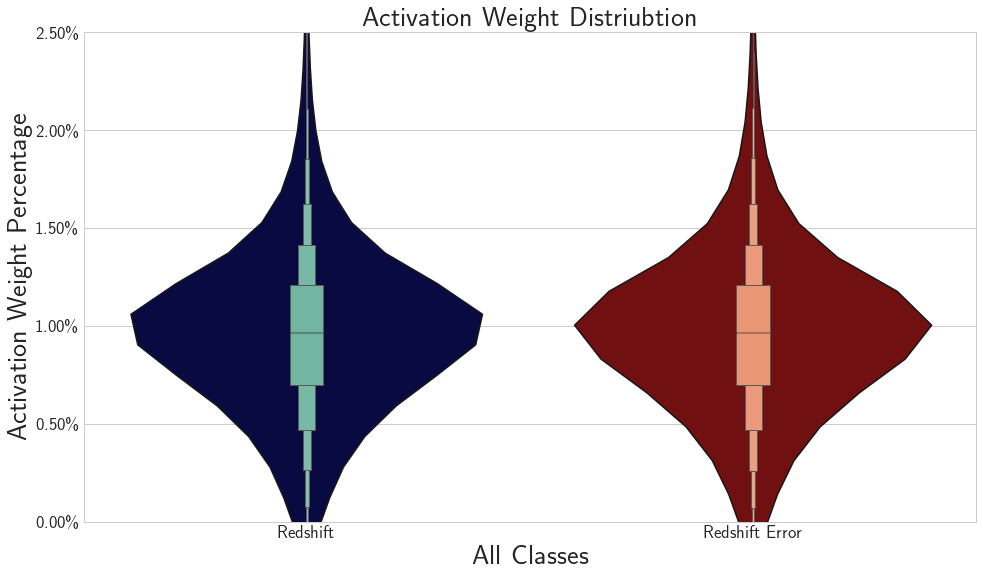

<Figure size 1152x648 with 0 Axes>

In [237]:
make_violin(dfza)

In [156]:
def show_cam(image_index, desired_class, counter):
    '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
    features_for_img = features[image_index,:,:]

  # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
    class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
#   class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
    class_activation_features = features_for_img

  # compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features,class_activation_weights)
    print(cam_output.shape)
    print(np.expand_dims(cam_output, axis=0).shape)
    cam_output = np.expand_dims(cam_output, axis=0)
    print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))

    from sklearn.preprocessing import minmax_scale, normalize
    cam_output = minmax_scale(cam_output, feature_range=(0,1), axis=1)
    cam_output = normalize(cam_output, norm='l1')

#     cam_output_softmax = softmax(cam_output)
    # cam_output_softmax = cam_output

    print(cam_output.sum(axis=1))
    cam_output_L = cam_output[:,:100]
    cam_output_z = cam_output[:,100:102]
    print(cam_output_L.shape, cam_output_z.shape)

    if (results[image_index][prediction] < 0.90):
        return False

    dfz = pd.DataFrame(data=cam_output_z, columns=["redshift", "redshift-error"])

    my_cmap = sns.light_palette("Navy", as_cmap=True)
    mpl.style.use("seaborn-whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(26, 8), gridspec_kw={'width_ratios': [3, 1]})
#     fig, ax = plt.subplots(figsize=(20, 8))

    dfz.plot(kind="bar", ax=axs[1], width=0.1, color=plt.cm.seismic(np.linspace(0, 1, 2)))
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.set_tick_params(labelsize=22)
    axs[1].yaxis.tick_right()
    axs[1].set_xlabel(r'Additional Features, $R$', fontsize=28)
    axs[1].set_ylabel(r'Activation Weight Percentage', fontsize=28)
    axs[1].set_xticklabels([])
    axs[1].legend(["Redshift", "Redshift Error"], fontsize=18, loc='best')
    axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=cam_output.sum(), decimals=1))
#     axs[1].yaxis.set_minor_formatter(ticker.ScalarFormatter())
#     axs[1].ticklabel_format(style='sci', axis='y', scilimits=(-10,2))
    print(dfz.head())

    # Heatmap axis
    ax = axs[0]

    formatter = ticker.PercentFormatter(xmax=cam_output.sum(), decimals=None)
#     formatter.set_scientific(True)
#     formatter.set_powerlimits((-2, 2))
    sns.set(font_scale=2)
    hm = sns.heatmap(cam_output_L,
                        cmap=my_cmap,
                        cbar=True,
                        robust=False,
                        ax=ax,
                        annot=False,
                        cbar_kws={"format": formatter},
                        vmax=cam_output.max(),
                        vmin=cam_output.min(), 
                    )

    print("MAX L:", cam_output_L.max(), np.argmax(cam_output_L))
    print("SUM L:", cam_output_L.sum())
    print("SUM z:", cam_output_z.sum())
    print("SUM CAM:", cam_output.sum())
    print("MIN CAM:", cam_output.min())
#     hm.collections[0].colorbar.set_label(r'Attention Weight Percentage', fontsize=28)
#     cb.ax.yaxis.set_major_formatter(plt.FuncFormatter(myfmt))
#     hm.collections[0].colorbar.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=1))
#     hm.collections[0].colorbar.set_ticks([0, .25, 0.50, .75, 1])
#     hm.collections[0].colorbar.set_ticklabels([r'0\%', r'25\%', r'50\%', r'75\%', r'100\%'])

    ax2 = ax.twinx()

    lc = ax2.plot(X_test[image_index], lw=5)
    ax2.legend(lc, [r'$g$', r'$i$', r'$r$', r'$u$', r'$y$', r'$z$'], loc="center left", markerfirst=False, bbox_to_anchor=(-0.15, 0.75), fontsize=26)

    ax2.grid(False)
    ax2.set_yticklabels([])
    ax2.get_yaxis().set_visible(True)
    ax2.yaxis.set_ticks_position('none') 

    ax.set_xlabel(r'Sequence Length, $L$', fontsize=28)
#     ax.set_title(r'')

    ax2.set_ylabel(r'Activation Weight Percentage', fontsize=28)

    ax.tick_params(which='minor', width=1.25)
    ax.tick_params(which='minor', length=3.5)
    ax.xaxis.set_tick_params(labelsize=26)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(r'${%d}$'))

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.get_yaxis().set_visible(False)
    ax.set_yticklabels([])

  # display the image
    fig.suptitle(rf"Predicted Class: {class_names[desired_class]} with Probability = {results[image_index][prediction]:.3f}", fontsize=36)
    fig.tight_layout()
    plt.savefig(
        f"{asnwd}/astronet/t2/plots/plasticc/cams/CAM-{class_names[desired_class]}-{counter}.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()
    plt.clf()

In [157]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class > (len(class_names) - 1):
        print("please choose a class between 0 and {len(class_names) - 1}")

    # go through the first 10000 images
    for i in range(0,50000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        random_sample = np.random.choice(len(results), 1)[0]
        if np.argmax(results[random_sample]) == desired_class:
            sc = show_cam(random_sample, desired_class, counter)
            if sc is not None:
                continue
            else:
                counter += 1

In [158]:
def make_cams(num_maps=40):

    for i in range(len(class_names)):
        show_maps(desired_class=i, num_maps=num_maps)

In [159]:
mpl.style.use("seaborn-whitegrid")

In [162]:
class_names

['$\\mu$-Lens-Single',
 'TDE',
 'EB',
 'SNII',
 'SNIax',
 'Mira',
 'SNIbc',
 'KN',
 'M-dwarf',
 'SNIa-91bg',
 'AGN',
 'SNIa',
 'RRL',
 'SLSN-I']

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5778922
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9723016
[0.9999999]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.004855385981500 0.004518247209489
MAX L: 0.023147207 77
SUM L: 0.9906262
SUM z: 0.009373633
SUM CAM: 0.9999999
MIN CAM: 0.0


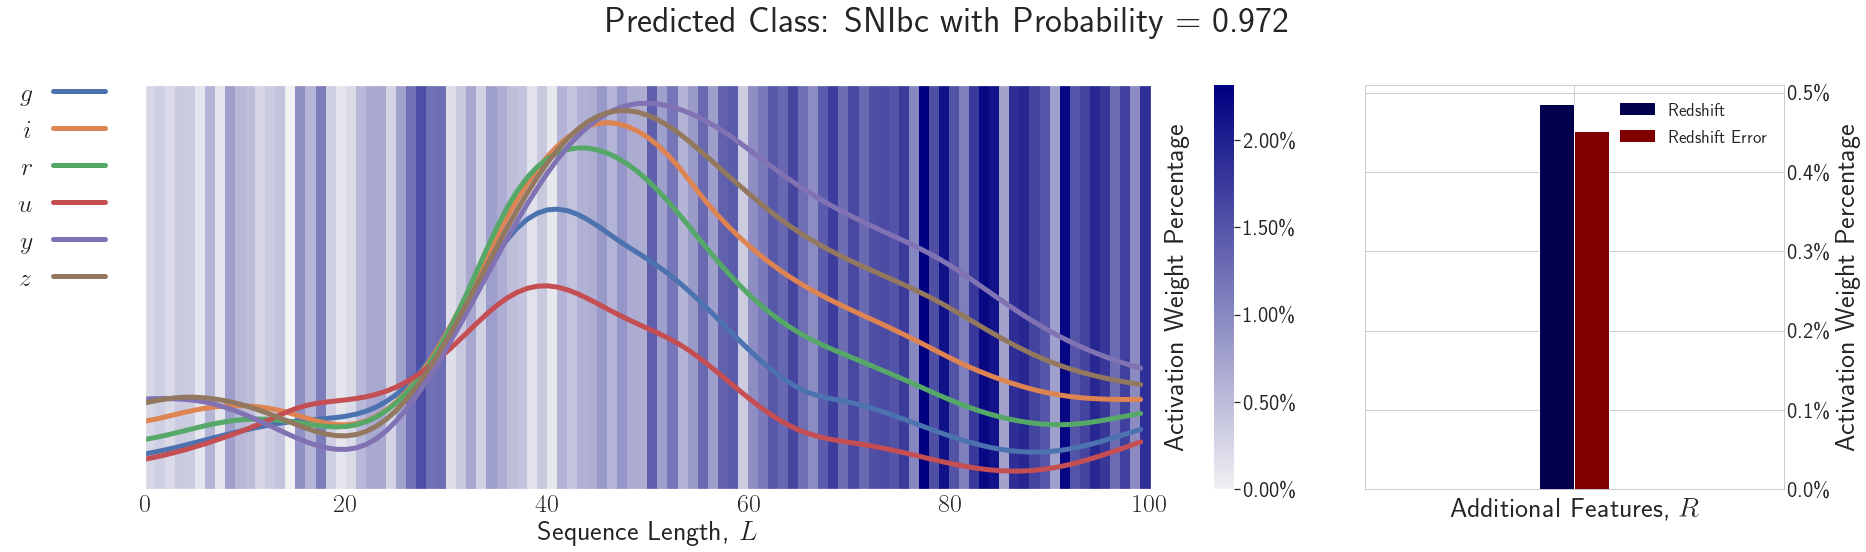

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8675488
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3260641
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40887126
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.45703226
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3854372
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.86674136
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5368183
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9594673
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.009766891598701 0.005776316393167
MAX L: 0.02822329 72
SUM L: 0.98445696
SUM z: 0.0155432075
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

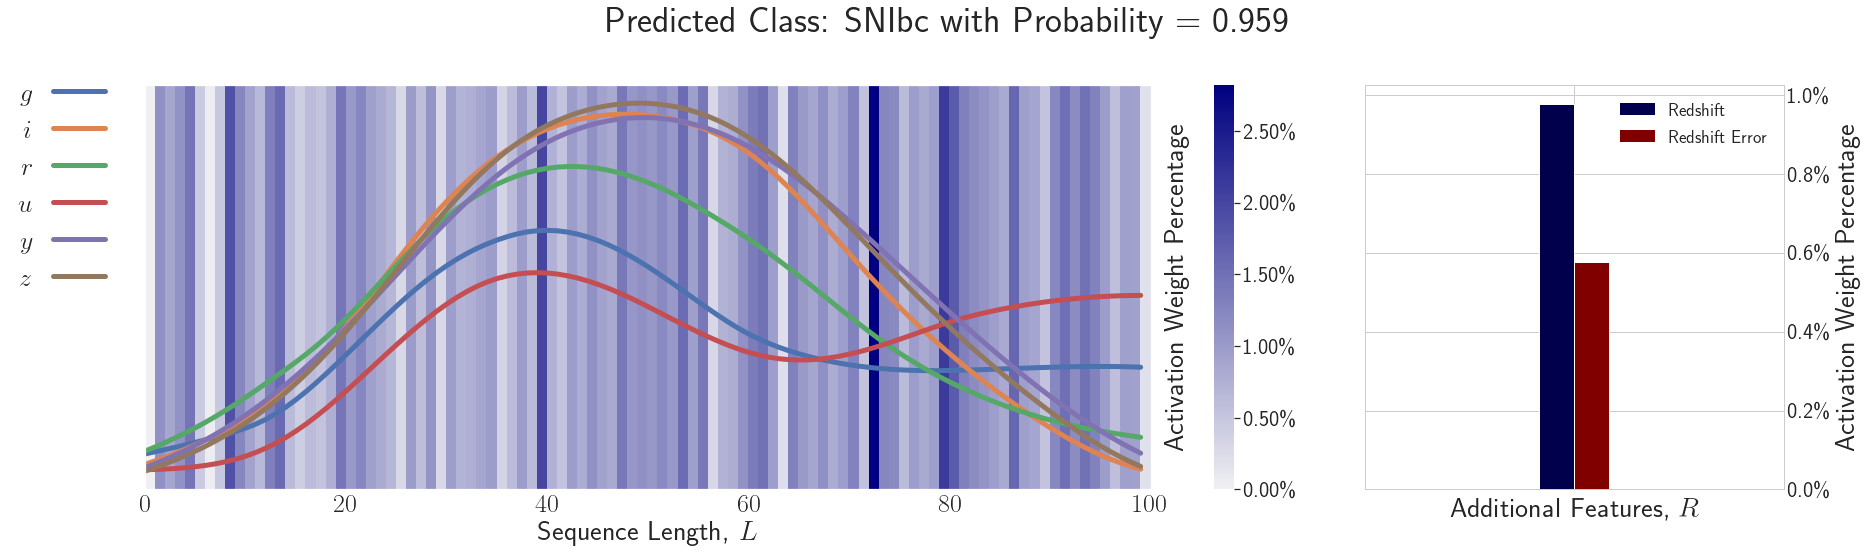

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3268367
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7171445
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.68473095
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8093181
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7850071
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3865088
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5641239
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4085141
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.35282364
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4972571
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5049949
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0

<Figure size 1440x216 with 0 Axes>

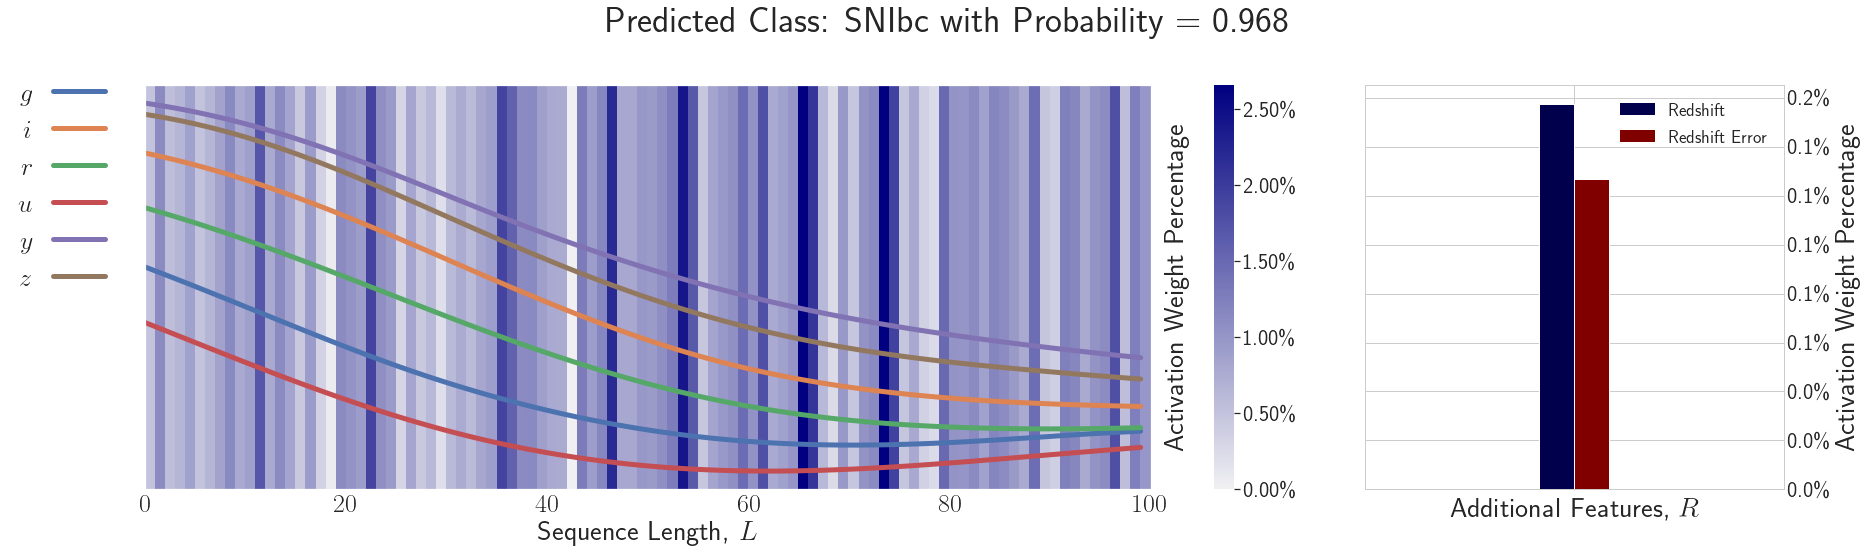

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7324287
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5214344
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6765793
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.32521182
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4740038
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.32767266
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.28859687
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5348725
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.421667
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.825985
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.89438176
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, P

<Figure size 1440x216 with 0 Axes>

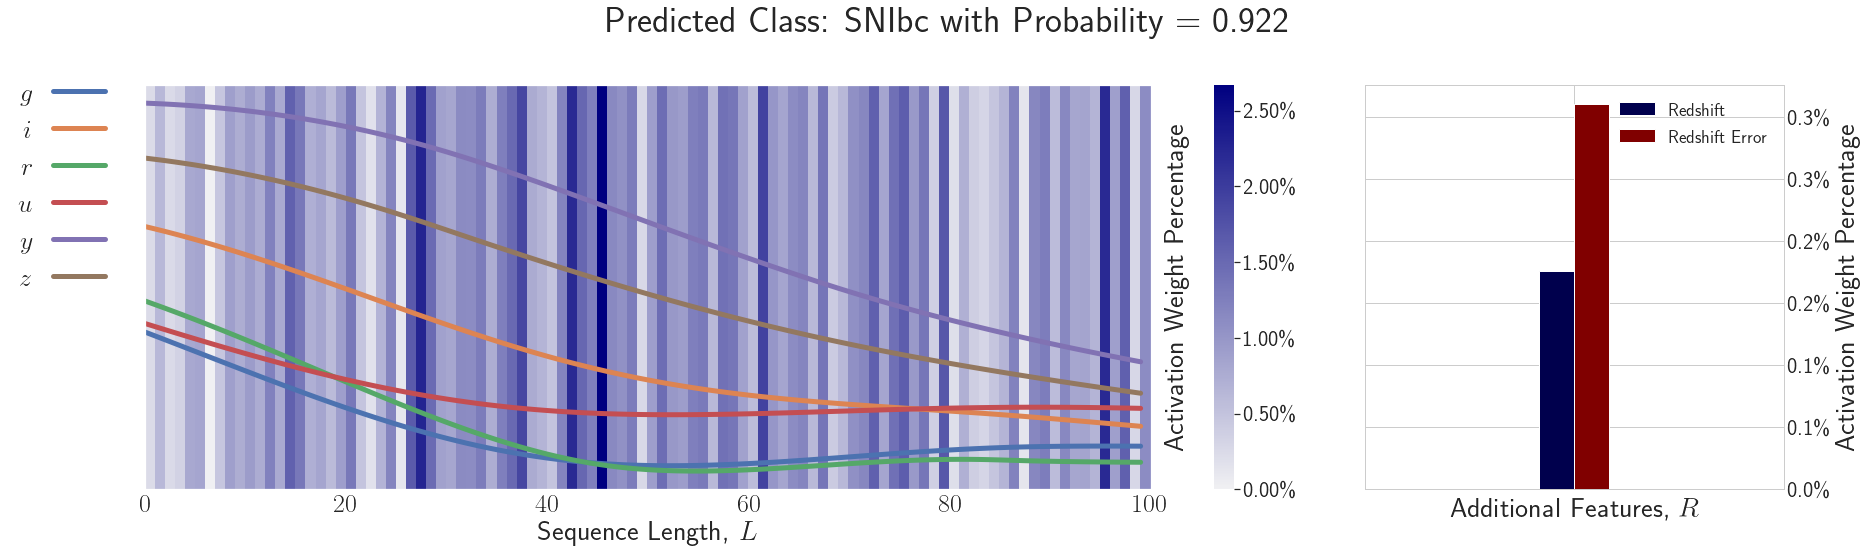

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7031741
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.77225506
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6781558
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33892483
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5653826
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.47416174
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.32282358
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5523168
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6393297
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.64742905
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49270946
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted

<Figure size 1440x216 with 0 Axes>

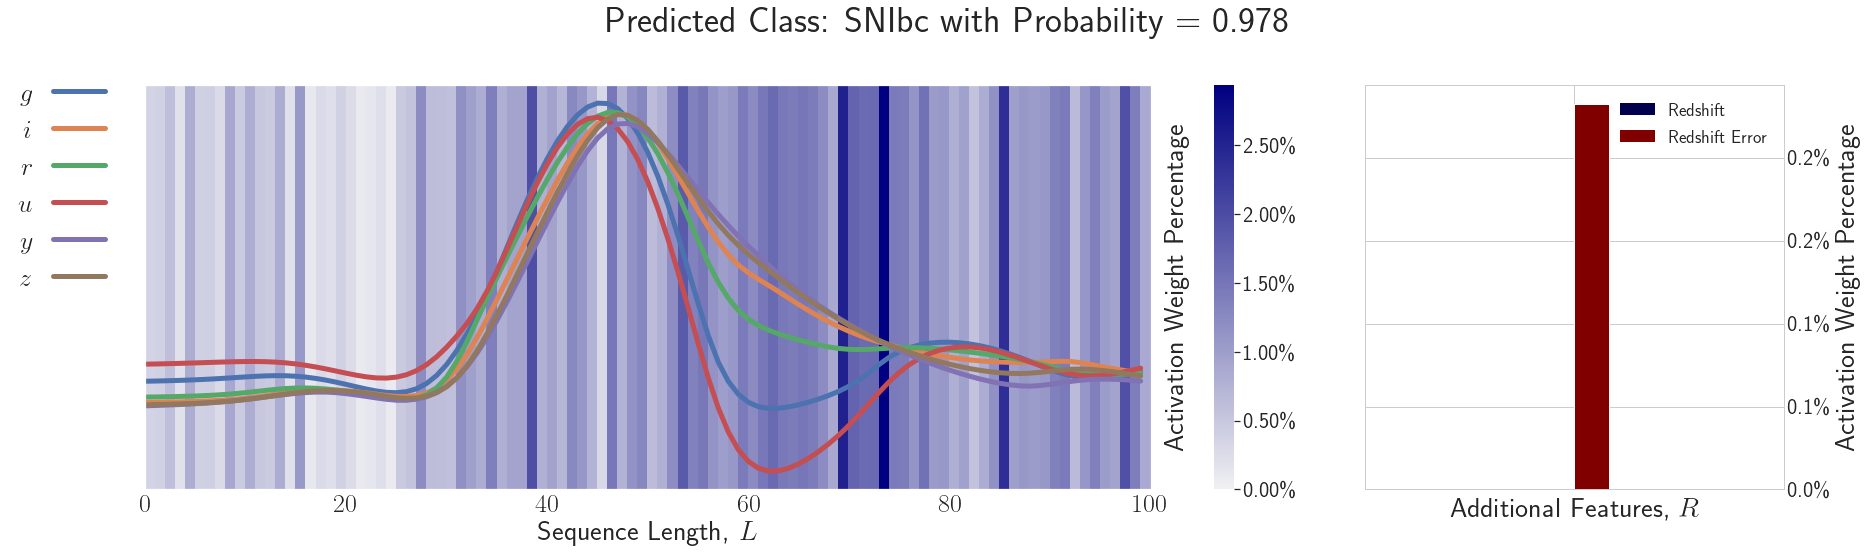

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.43807483
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.97610086
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.004316570237279 0.002778648165986
MAX L: 0.021348111 95
SUM L: 0.9929049
SUM z: 0.0070952186
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

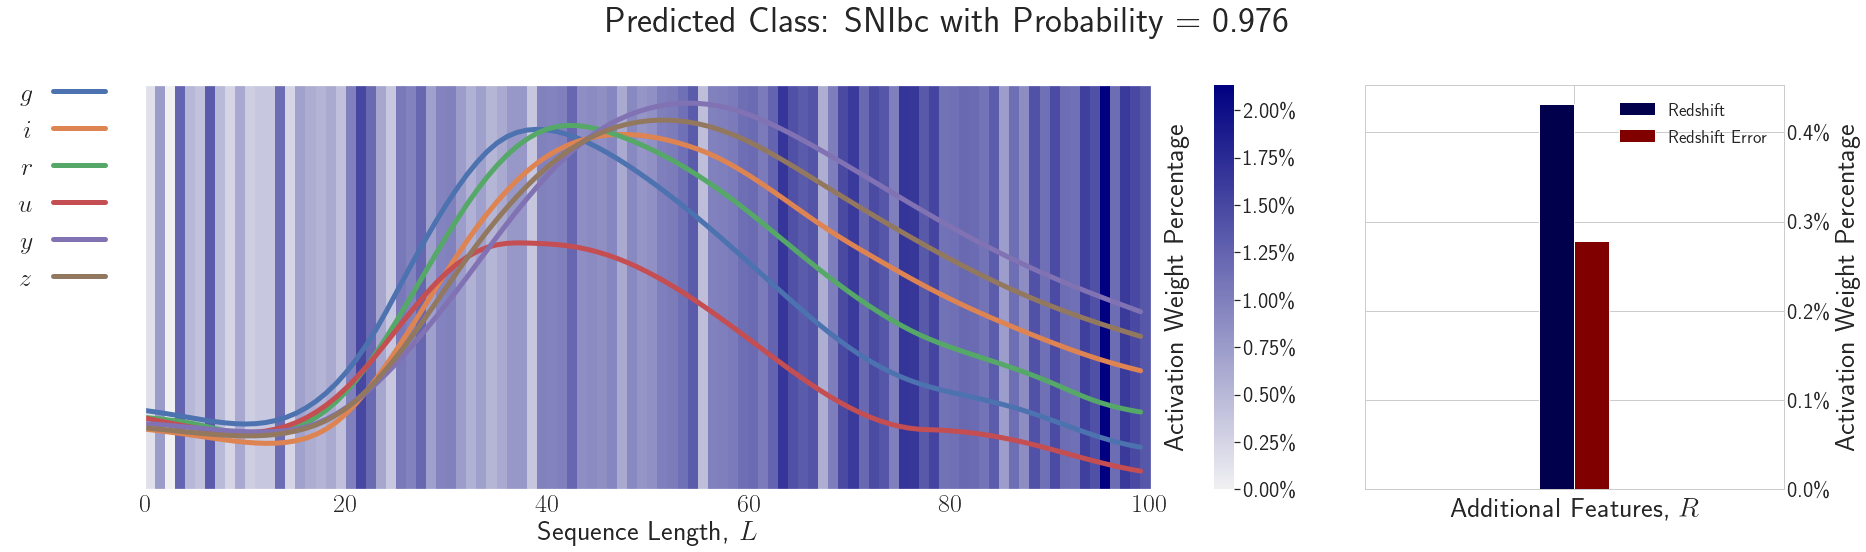

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.44769624
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.88407105
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.893645
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8507283
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.43919566
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.87852055
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9400158
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.004321352578700 0.000794664782006
MAX L: 0.029678132 50
SUM L: 0.99488395
SUM z: 0.0051160175
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

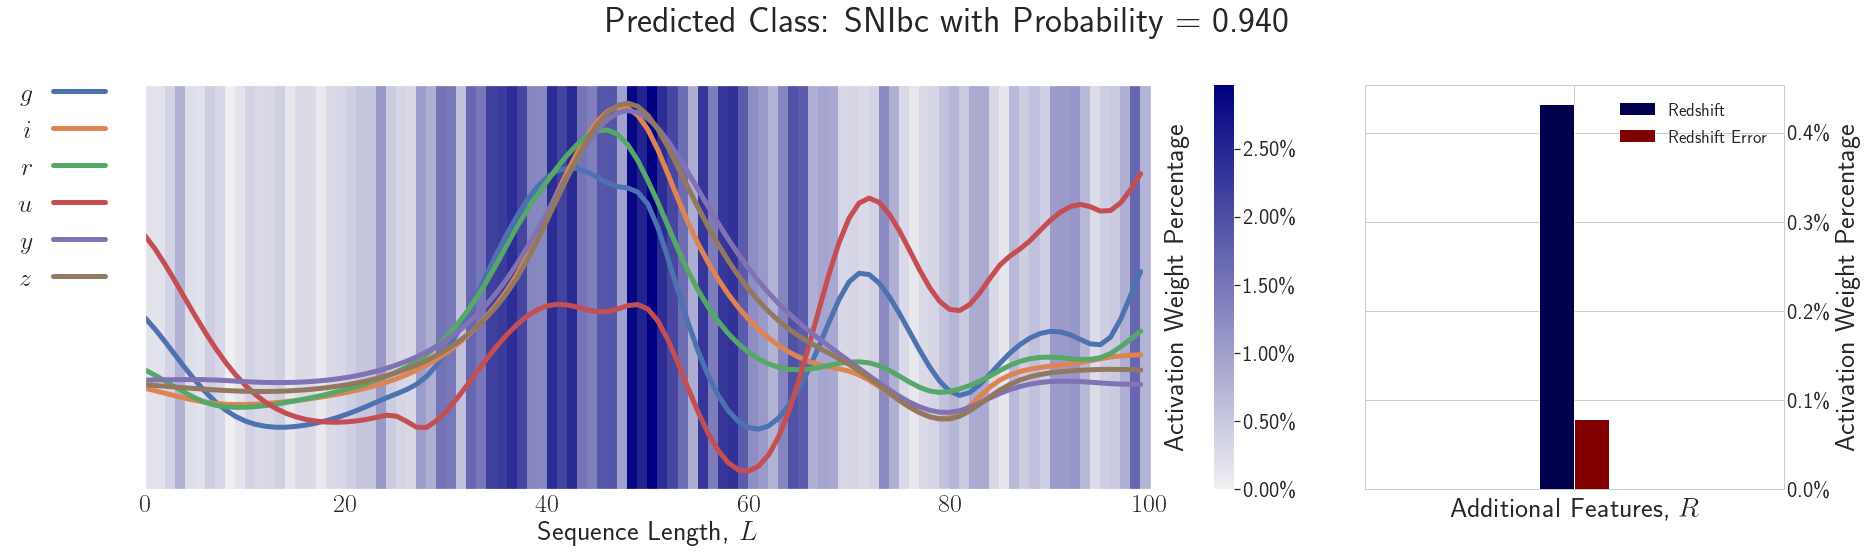

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.42676944
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.34449732
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40289852
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6736963
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6524937
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49962977
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.65063524
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5813521
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6440796
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40766498
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.31020385
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class =

<Figure size 1440x216 with 0 Axes>

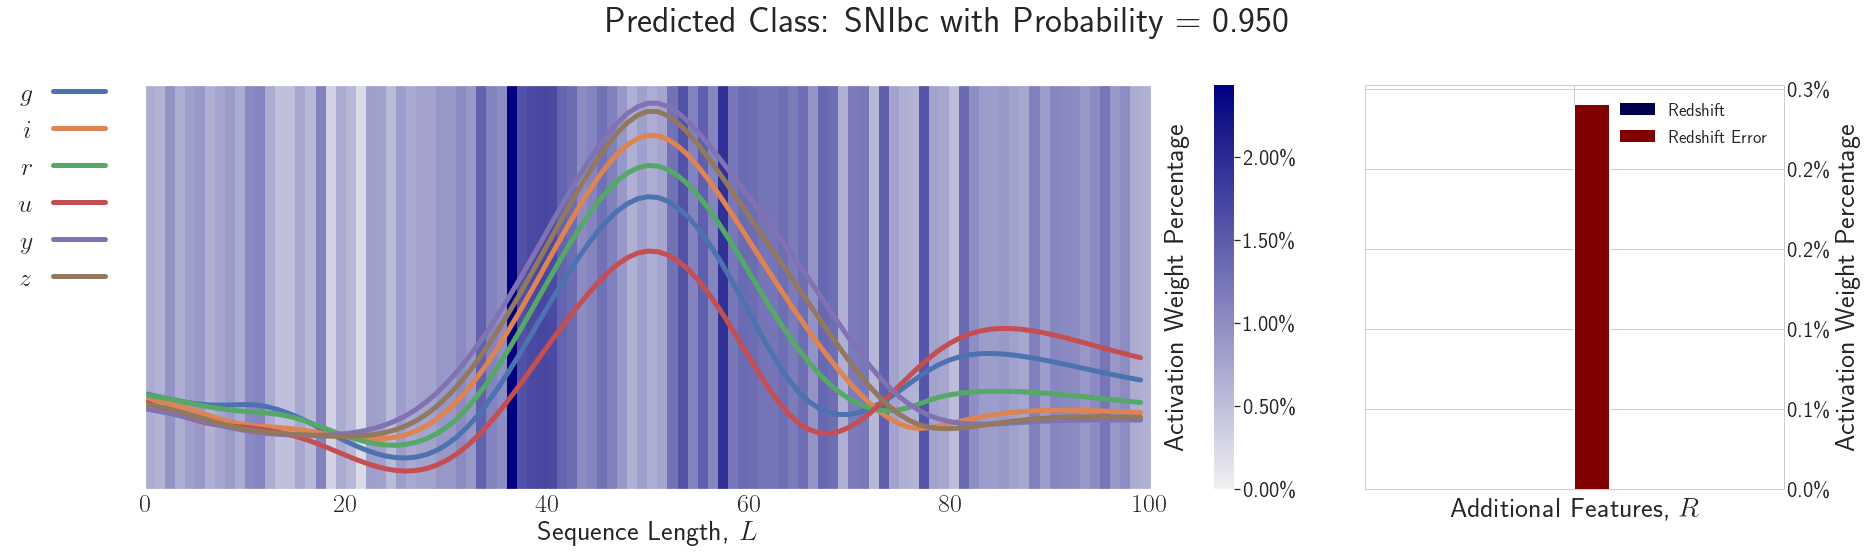

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49072373
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5296234
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.43453658
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40556827
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.59880275
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50317484
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41163468
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5098906
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.97797215
[0.9999999]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003023219527677 0.003800362348557
MAX L: 0.024493571 96
SUM L: 0.99317634
SUM z: 0.0068235816
SUM CAM: 0.9999999
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

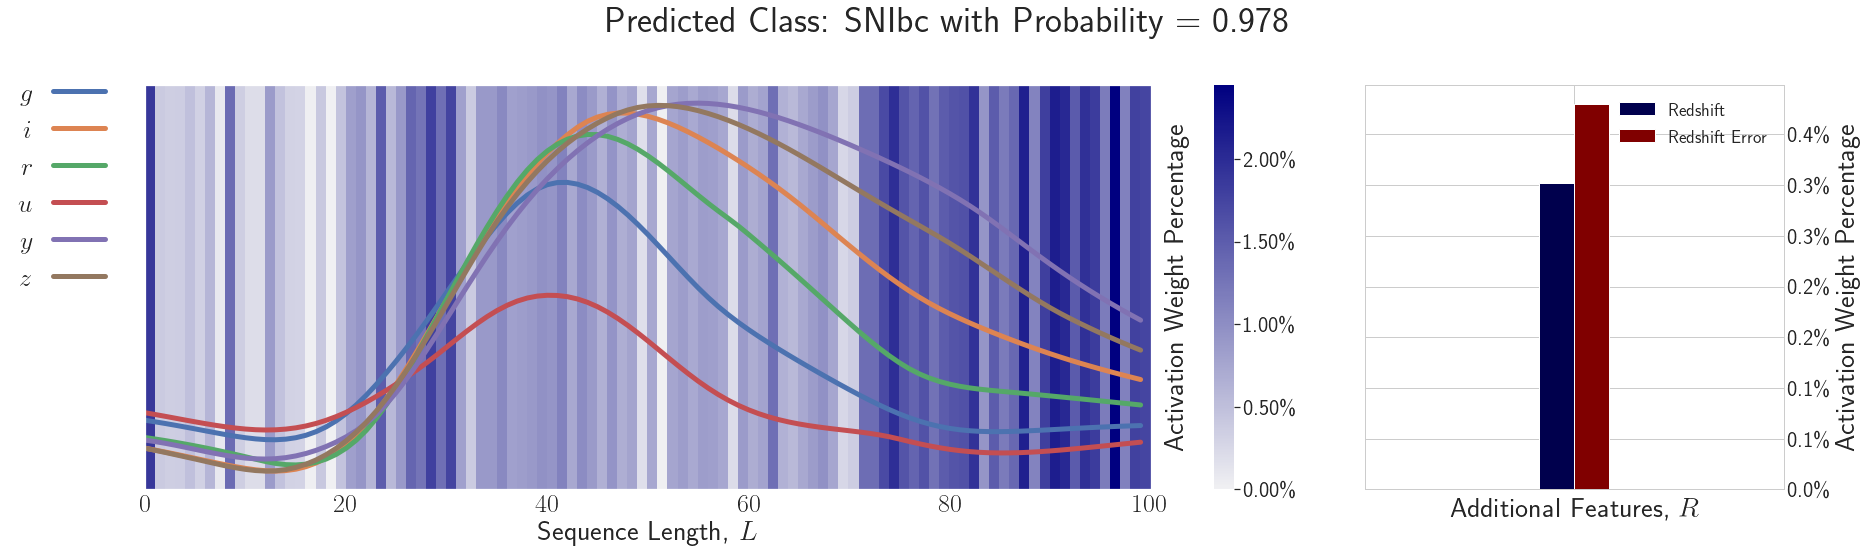

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41669023
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.51342076
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.62823534
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.92381626
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.008162821643054 0.005320288706571
MAX L: 0.030064179 86
SUM L: 0.9865169
SUM z: 0.013483111
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

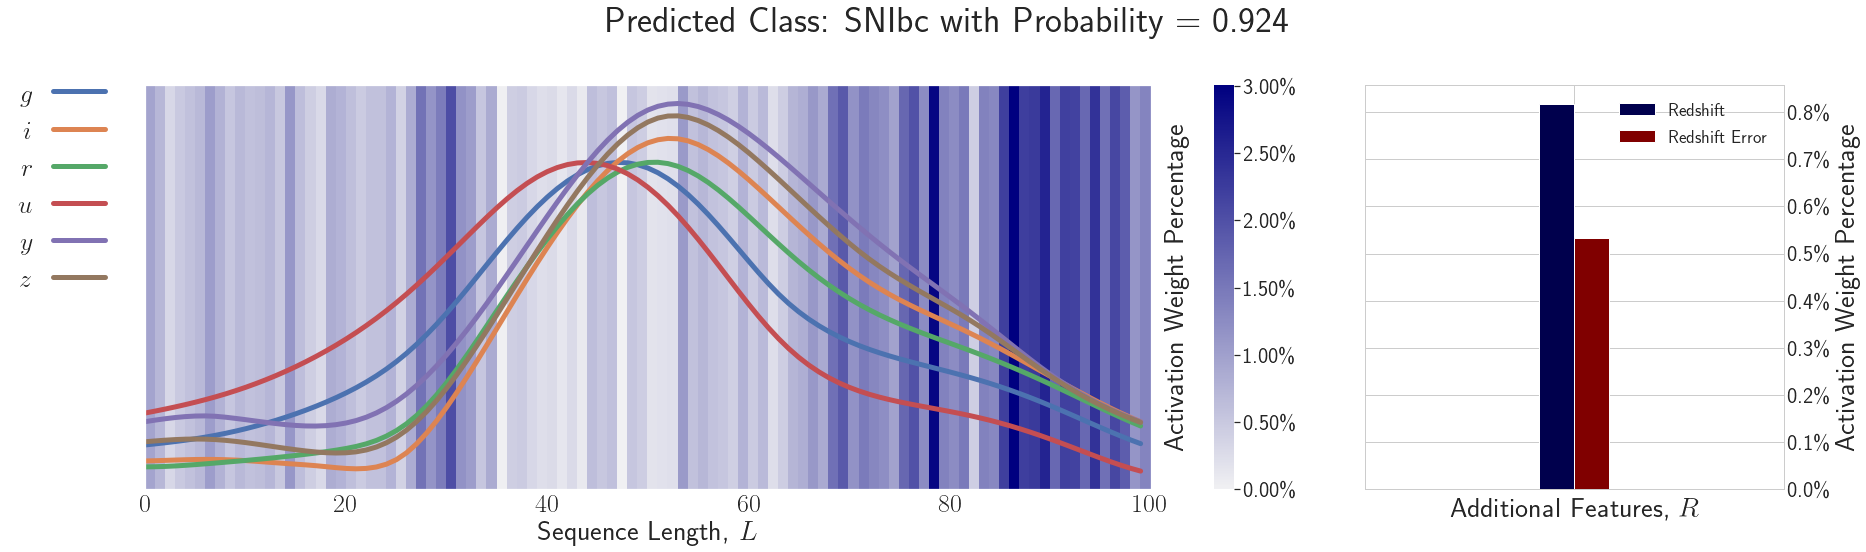

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.38856828
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7355946
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5957335
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8003554
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.34849685
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.73203176
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.57421744
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5228116
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.56944937
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40296745
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4138474
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.32

<Figure size 1440x216 with 0 Axes>

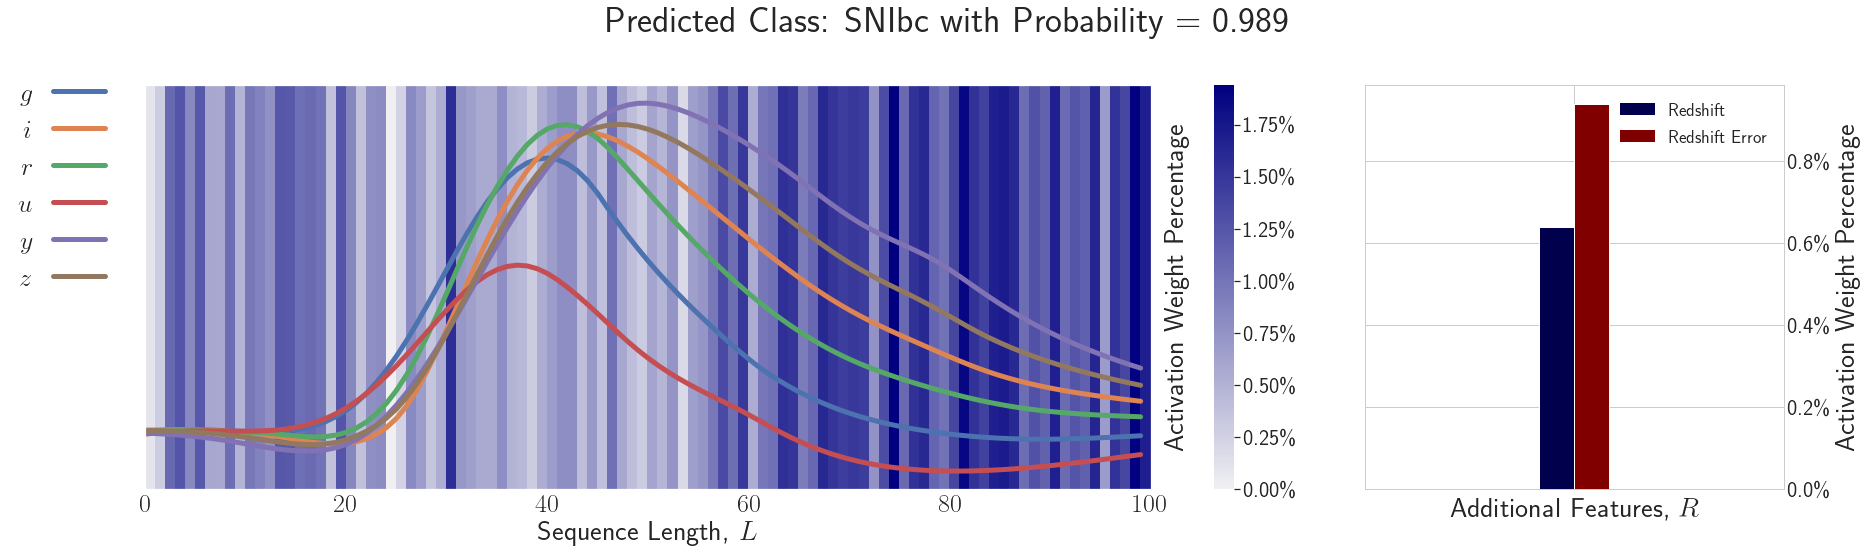

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33932784
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3202469
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4081451
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7566085
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.721167
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.94930506
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.000060007943830
MAX L: 0.021328818 25
SUM L: 0.9999399
SUM z: 6.0007944e-05
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

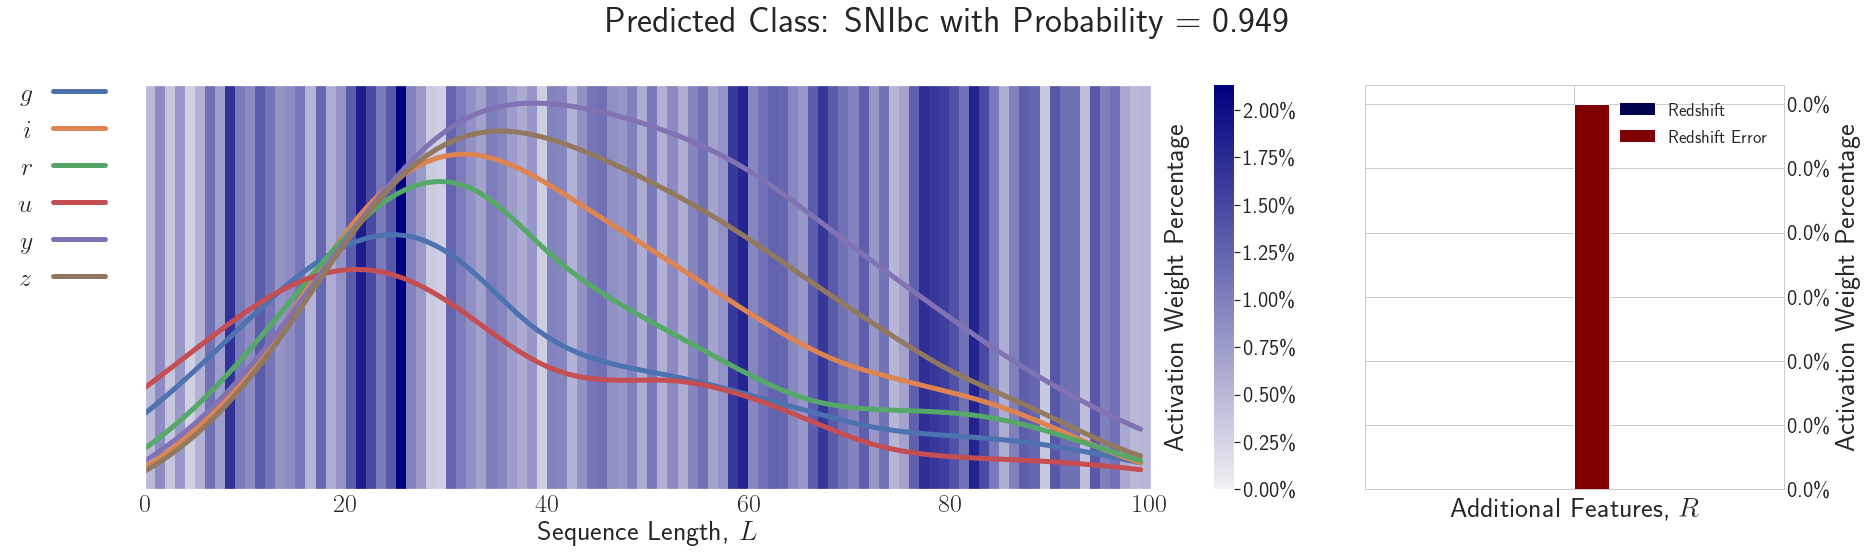

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.2726783
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4536126
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.66308355
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6636557
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.516616
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5091029
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9492365
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.013179135508835 0.006889724172652
MAX L: 0.017654113 96
SUM L: 0.9799311
SUM z: 0.02006886
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

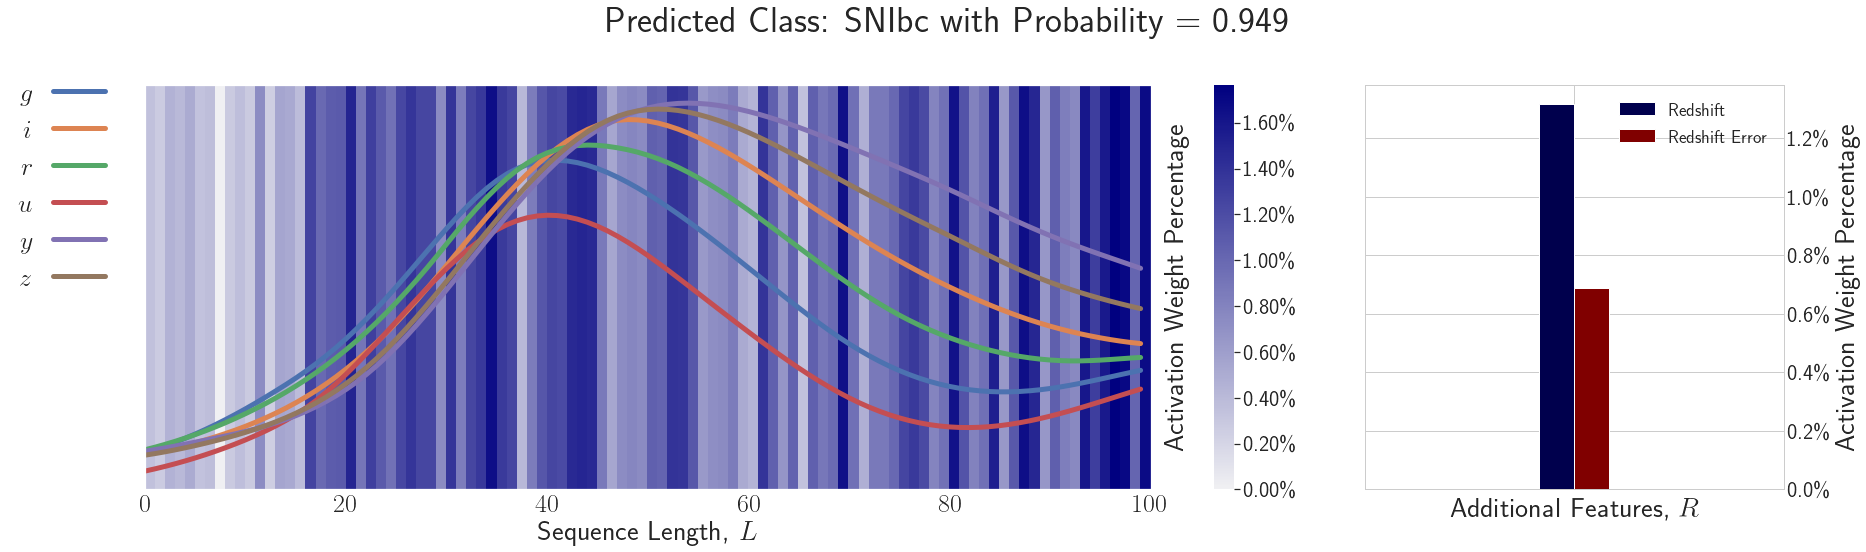

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.58474255
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.34474057
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3935916
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.25861004
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40843117
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48320684
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.30358967
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.42045876
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3126442
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8886456
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48971343
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probabil

<Figure size 1440x216 with 0 Axes>

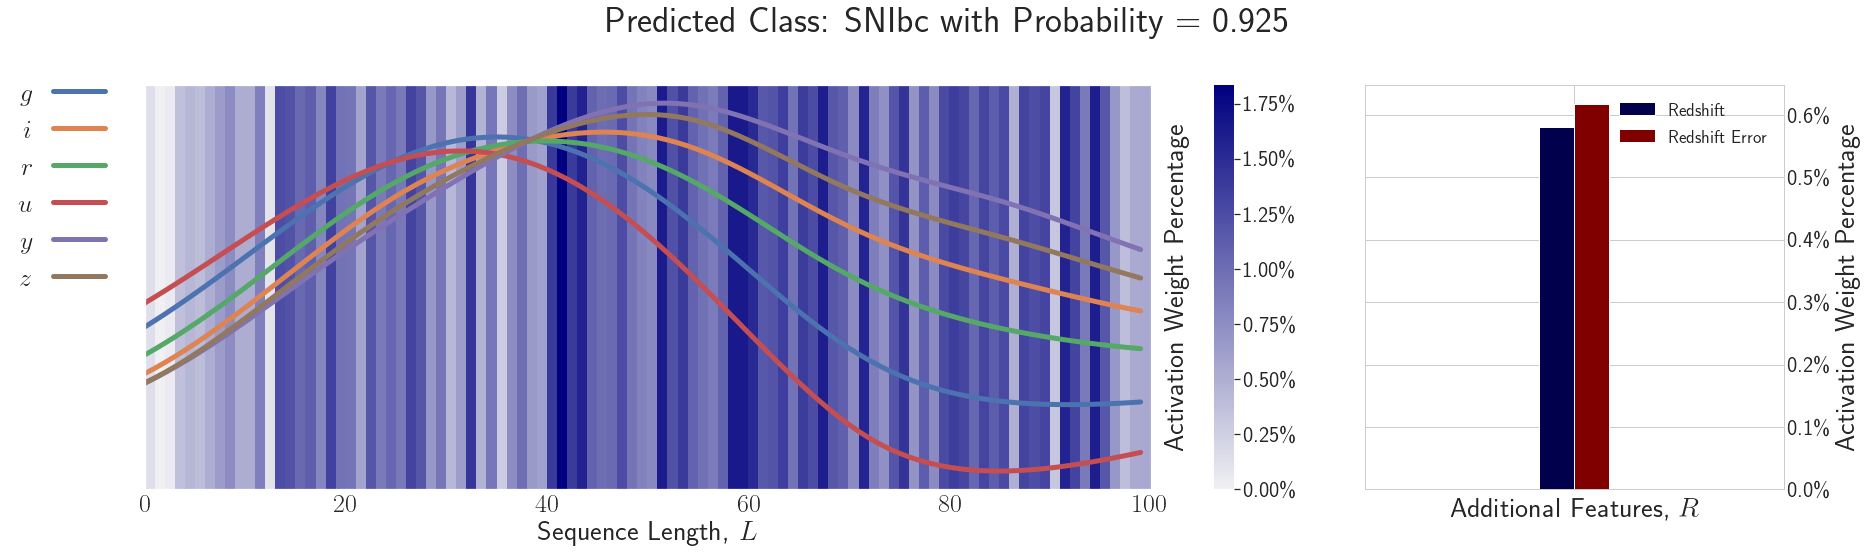

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.45249963
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33118105
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41226456
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.53165936
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49957496
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5411985
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8917521
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8093651
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.59086293
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5506122
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3816112
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted

<Figure size 1440x216 with 0 Axes>

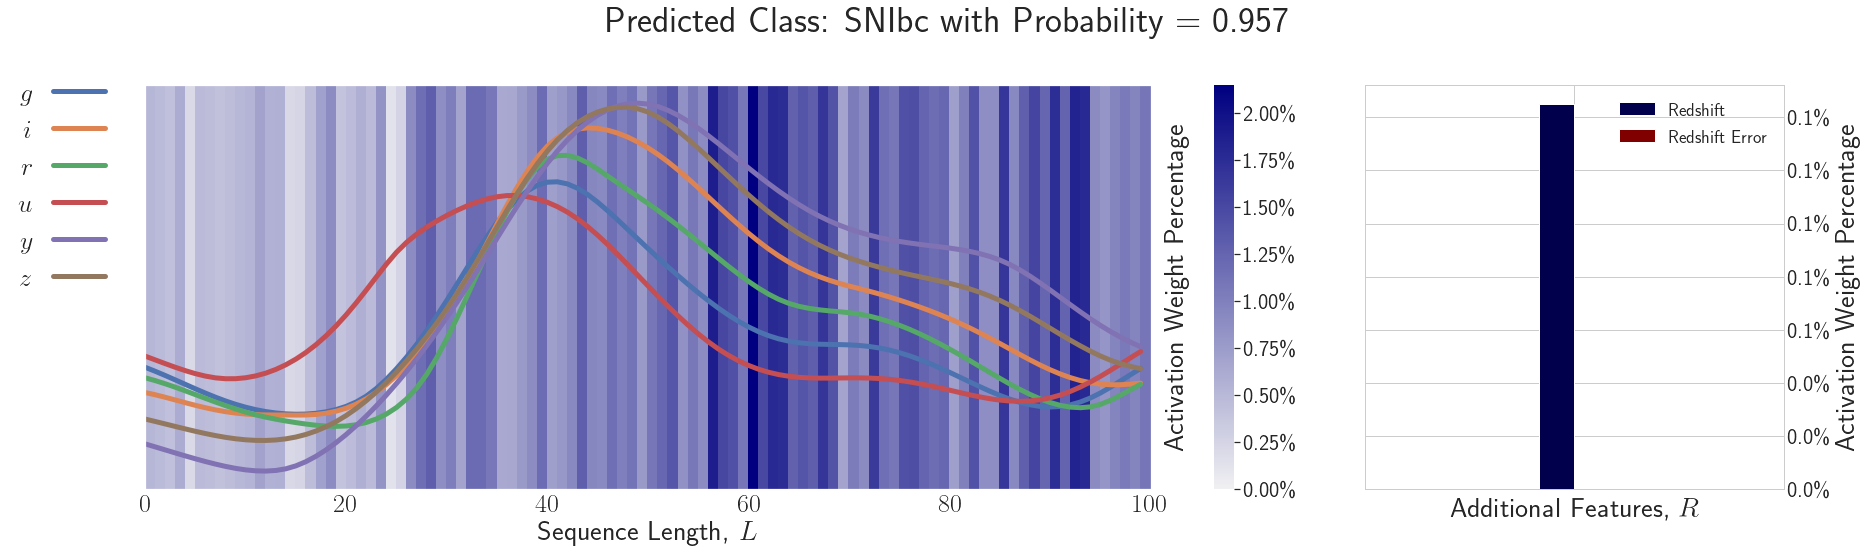

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9186886
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.010929745621979 0.011967341415584
MAX L: 0.030834088 90
SUM L: 0.977103
SUM z: 0.022897087
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

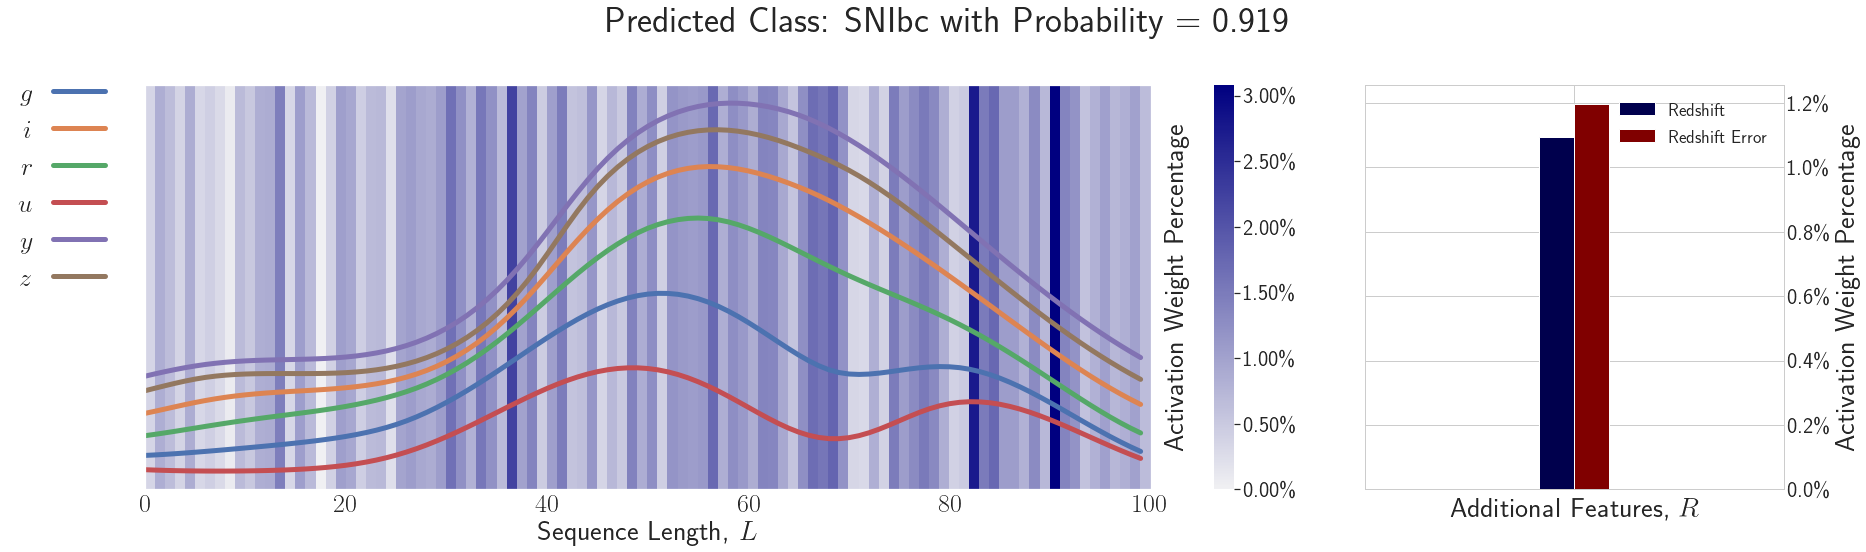

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.25225458
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3376767
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7288091
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7701161
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.35483623
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3515463
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.91091216
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.002198318019509
MAX L: 0.015988696 99
SUM L: 0.99780166
SUM z: 0.002198318
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

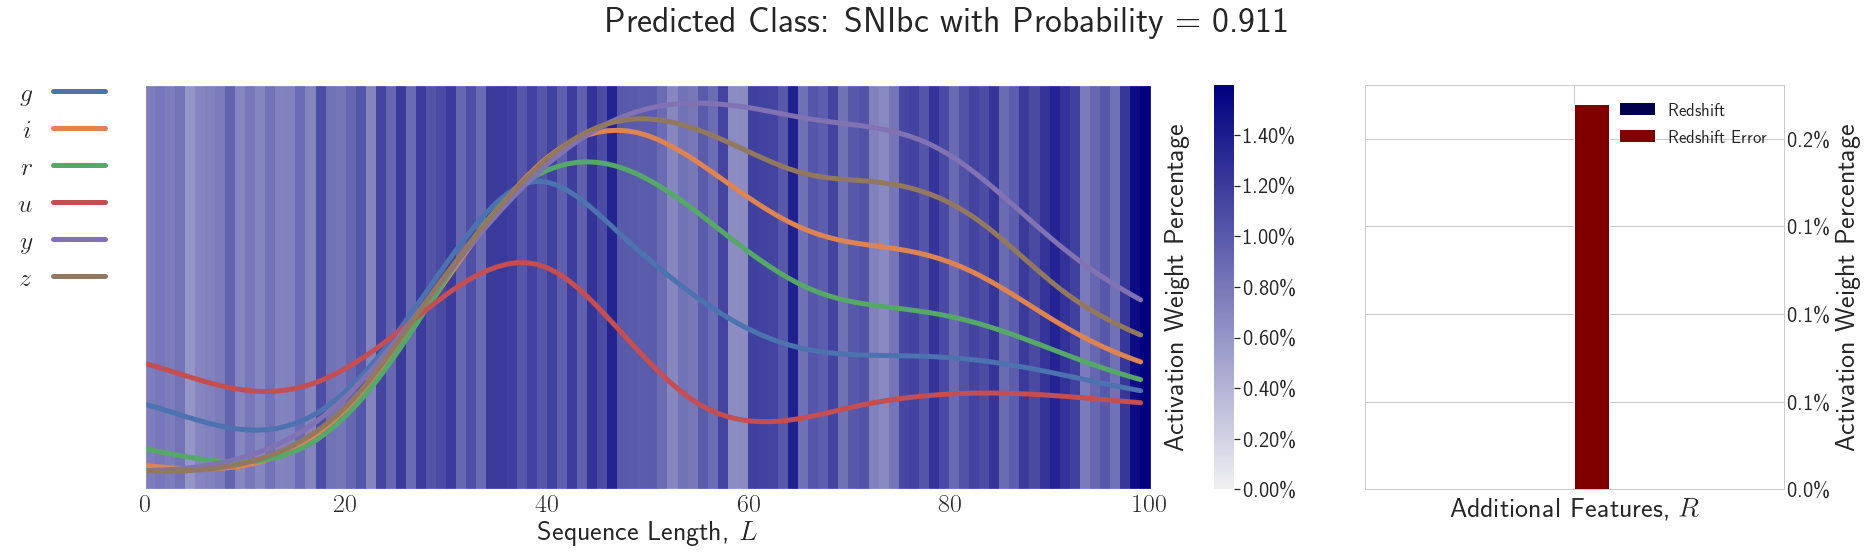

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41435504
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33976567
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.47896656
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8407199
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6525915
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.75866365
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9846698
[0.9999999]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.005084772128612 0.003069867379963
MAX L: 0.032010127 64
SUM L: 0.99184525
SUM z: 0.00815464
SUM CAM: 0.9999999
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

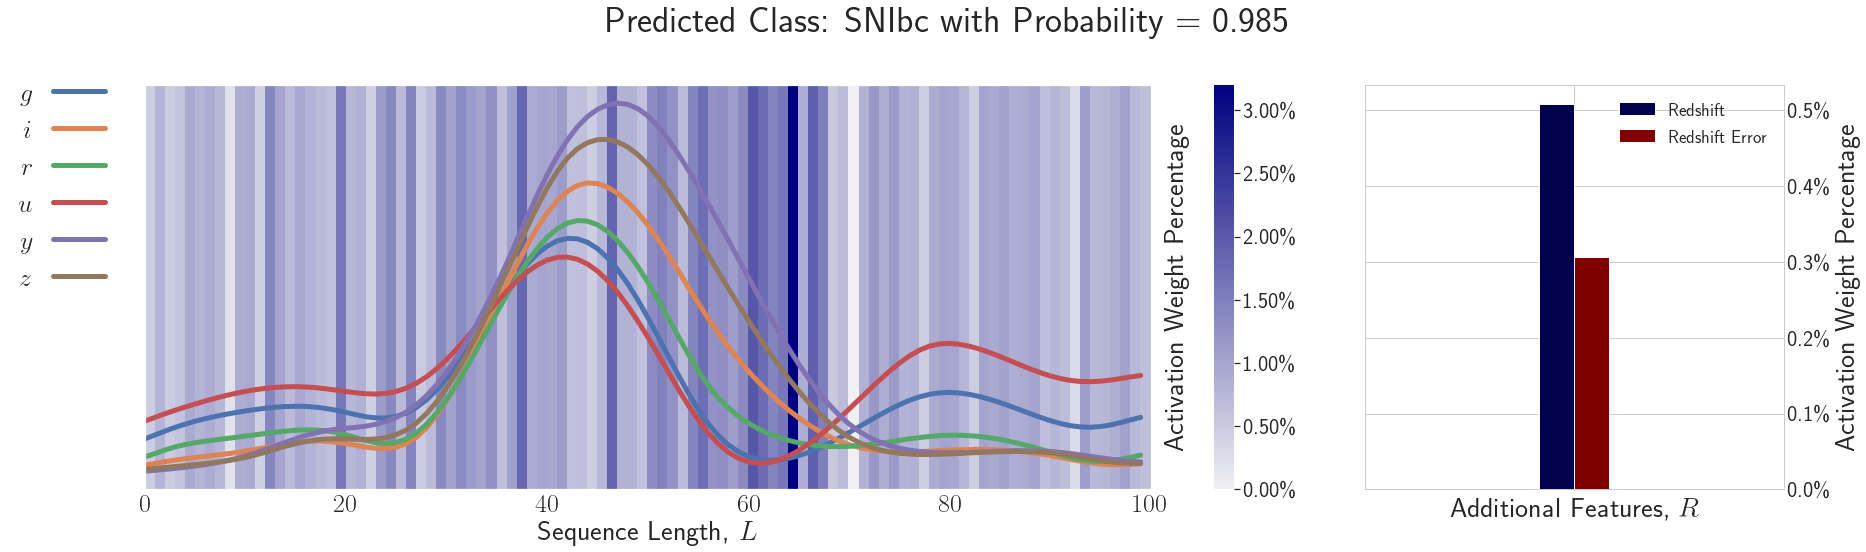

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9341274
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.004268865101039 0.003622835734859
MAX L: 0.02429969 88
SUM L: 0.99210835
SUM z: 0.007891701
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

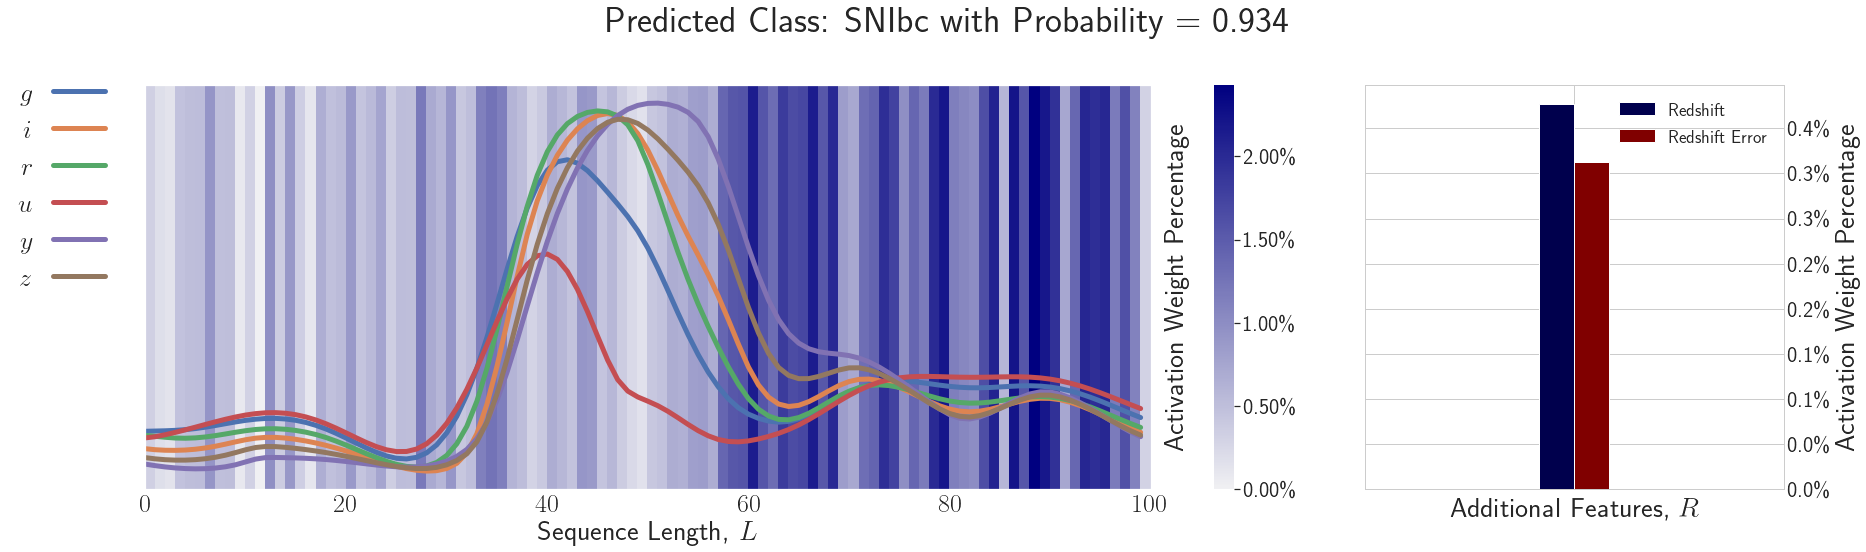

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.26652578
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.45181063
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4128336
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5098474
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.71638113
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.62841713
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6458103
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.59854144
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4647394
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.91654056
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.007238979451358 0.016181997954845
MAX L: 0.02074159 65
SUM L: 0.97657895
SUM z: 0.0234

<Figure size 1440x216 with 0 Axes>

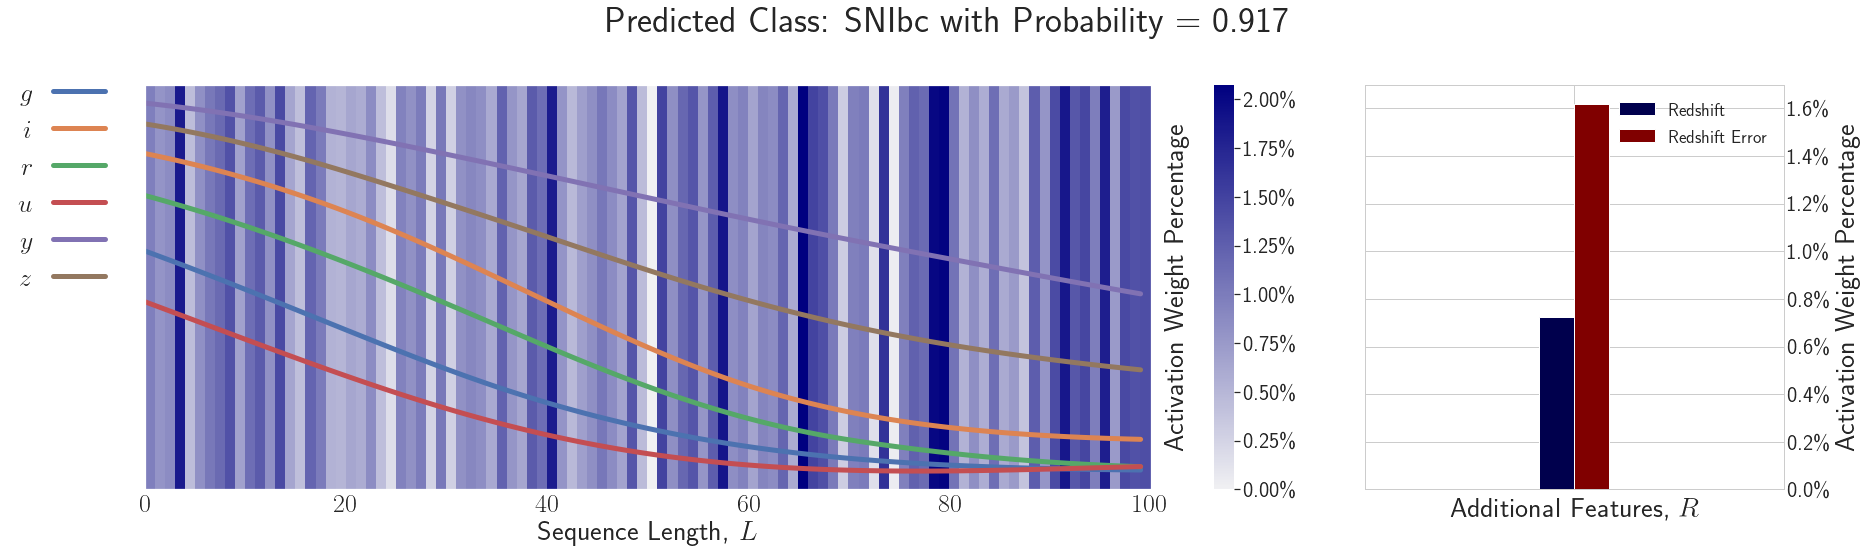

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8912074
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6914834
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.54808813
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9562059
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.002138091716915 0.000817942200229
MAX L: 0.034576576 65
SUM L: 0.99704397
SUM z: 0.002956034
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

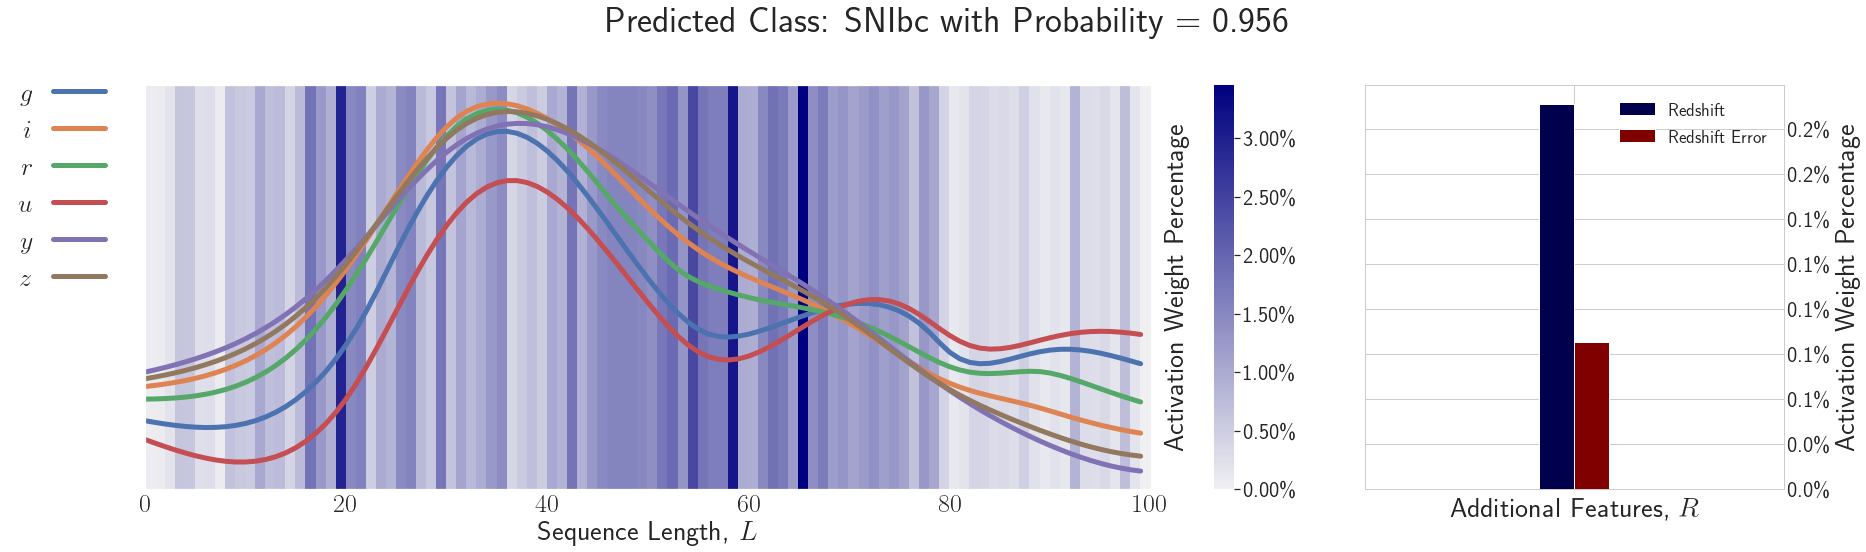

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48056895
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8702653
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7400798
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8001368
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33456784
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.86110944
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7024385
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5794171
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.76733476
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7851603
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.785522
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8336457
[0.99

<Figure size 1440x216 with 0 Axes>

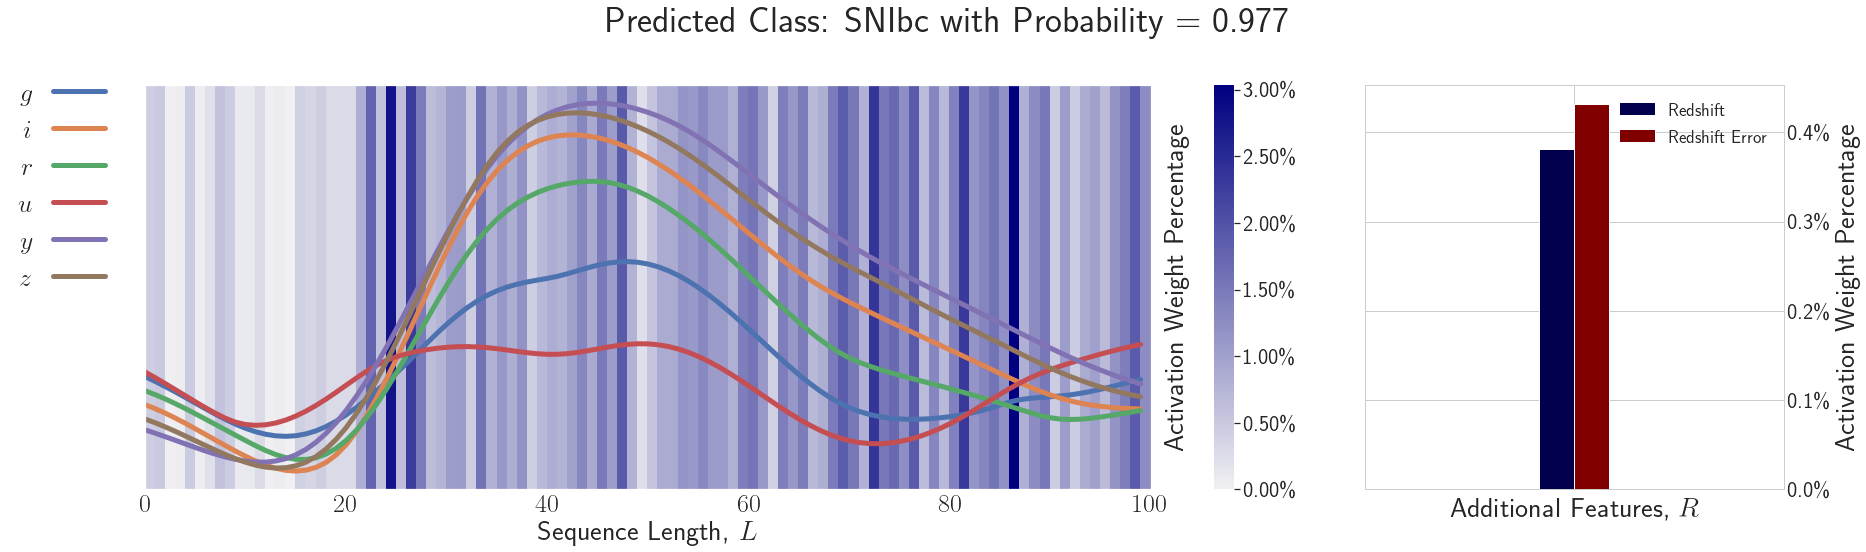

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4164424
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.52676463
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.37612104
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5090272
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8295156
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.36179525
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.28498584
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.29877213
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8401378
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50584
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.45045984
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted C

<Figure size 1440x216 with 0 Axes>

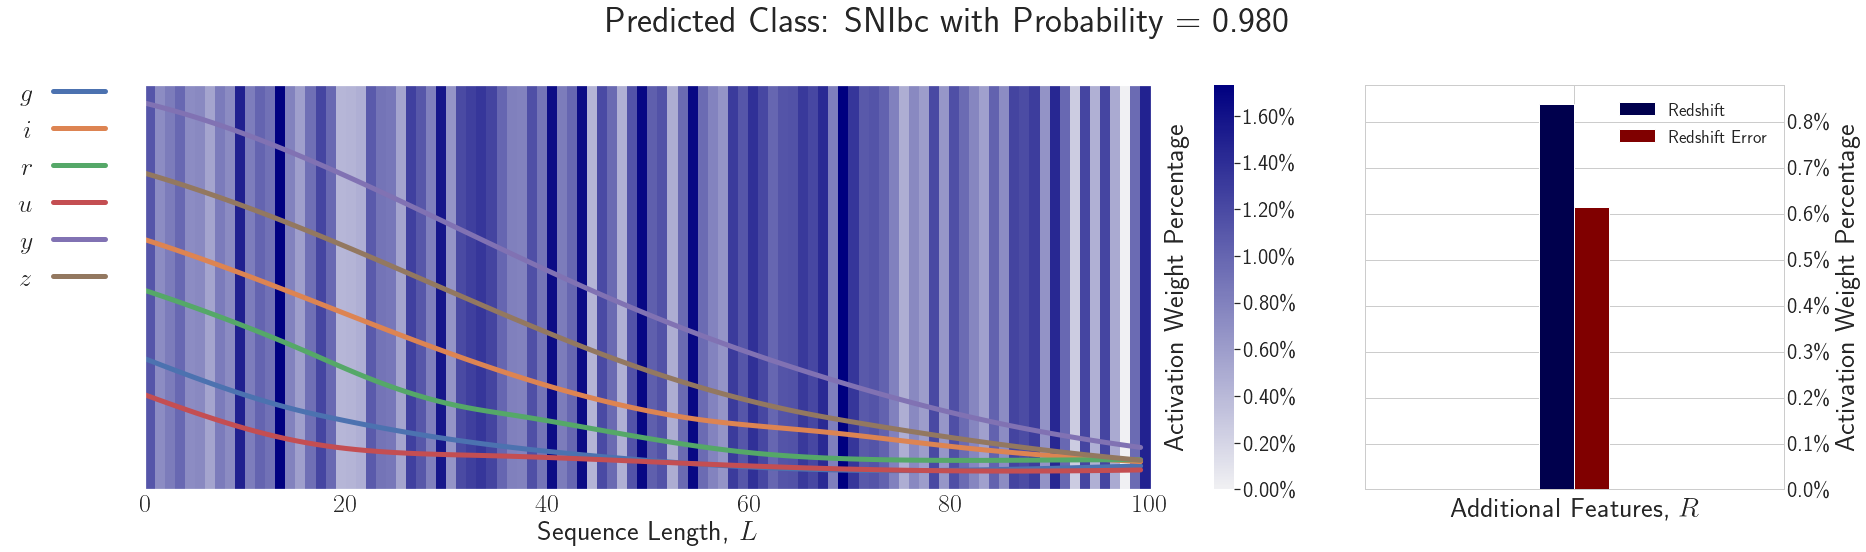

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48482192
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5480322
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6751976
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8468177
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41067883
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48090887
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9313409
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.007049623411149 0.003739992156625
MAX L: 0.030214446 89
SUM L: 0.9892104
SUM z: 0.010789616
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

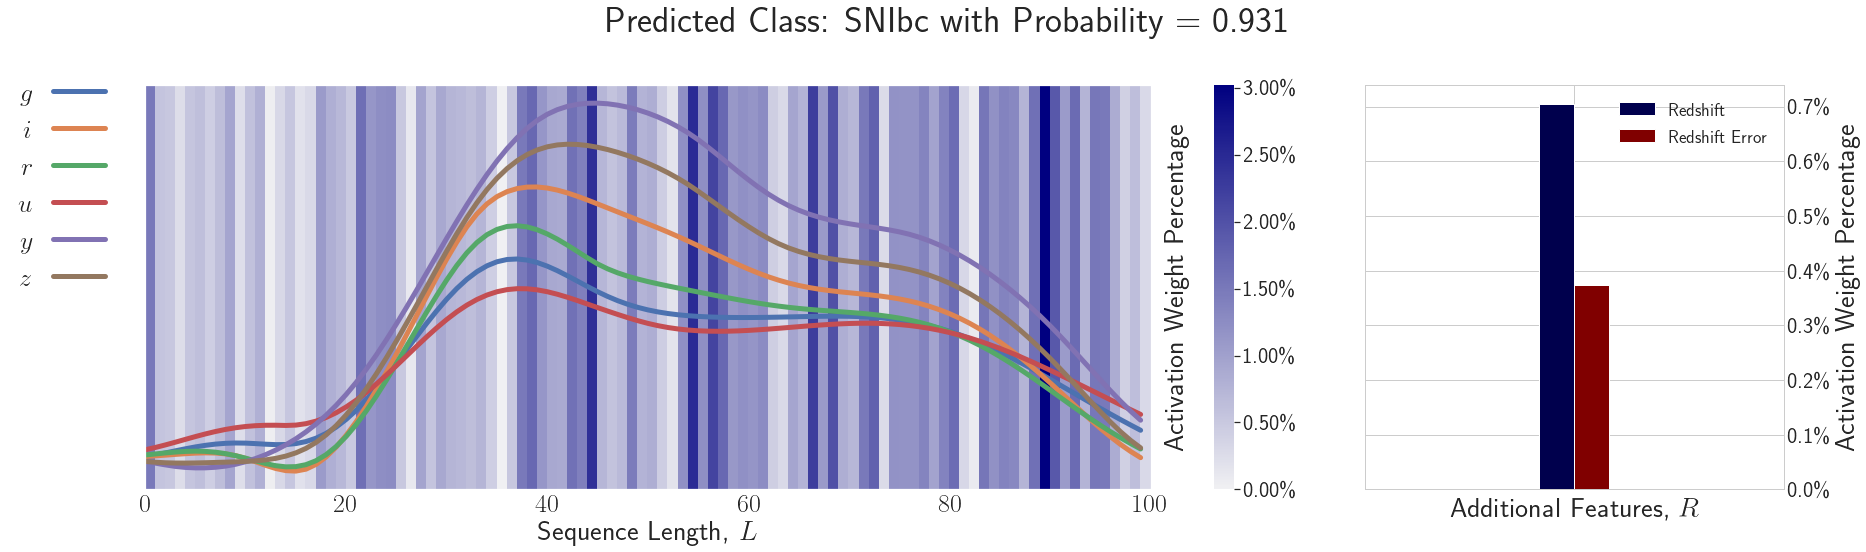

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6497174
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.79584986
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5359721
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9166089
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.010343148373067 0.006418418604881
MAX L: 0.022135392 78
SUM L: 0.9832385
SUM z: 0.016761567
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

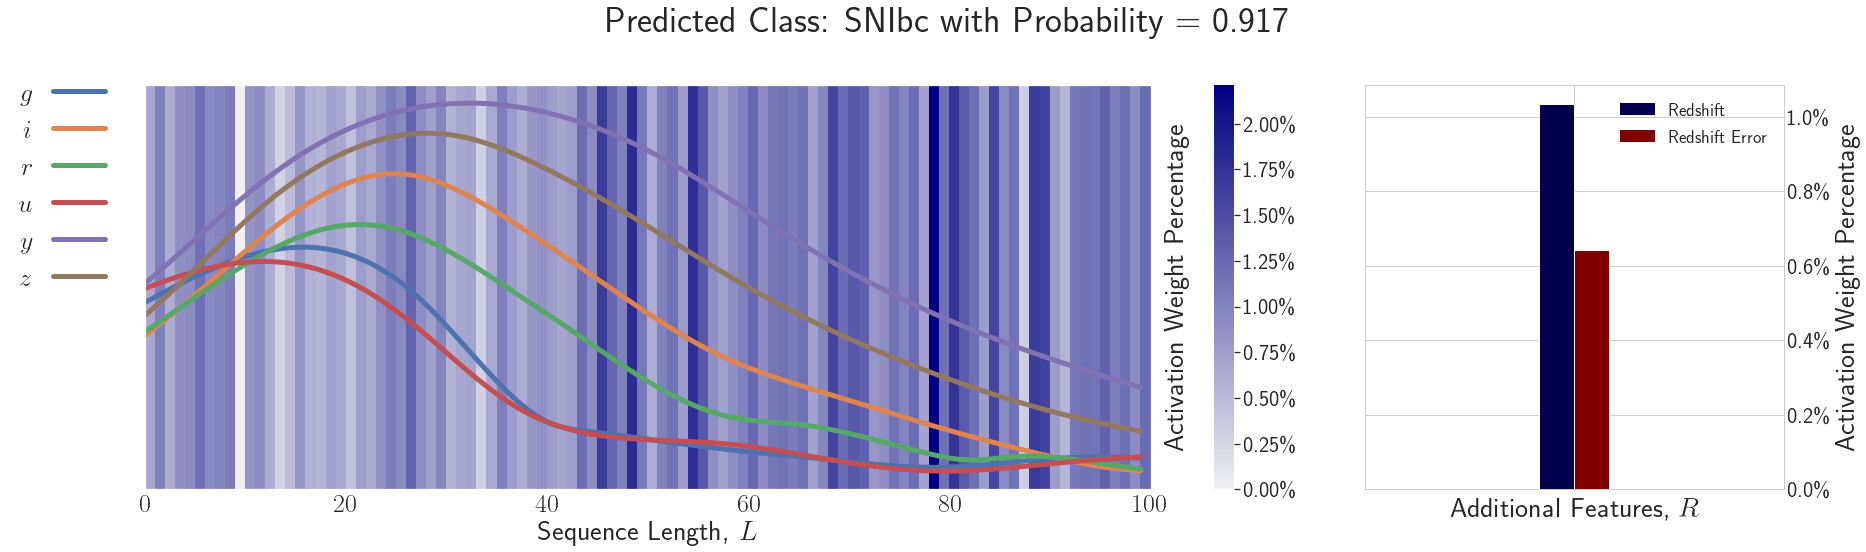

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.78579825
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33483168
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.37984577
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33802778
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9227346
[0.9999999]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.002520679961890
MAX L: 0.020423286 61
SUM L: 0.9974792
SUM z: 0.00252068
SUM CAM: 0.9999999
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

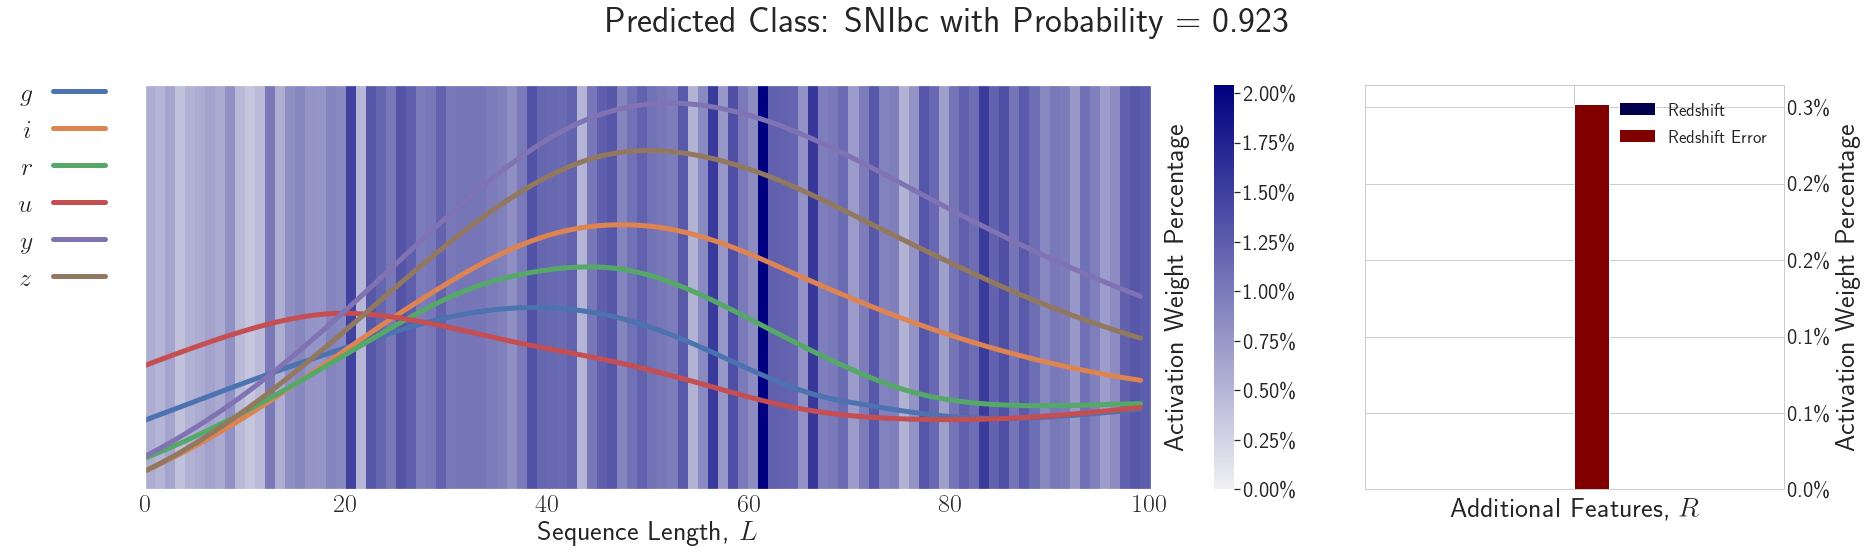

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.37171015
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.2167641
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5515845
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6357008
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.60576314
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.39055055
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6511816
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3732782
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.58914757
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49377993
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49124184
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability

<Figure size 1440x216 with 0 Axes>

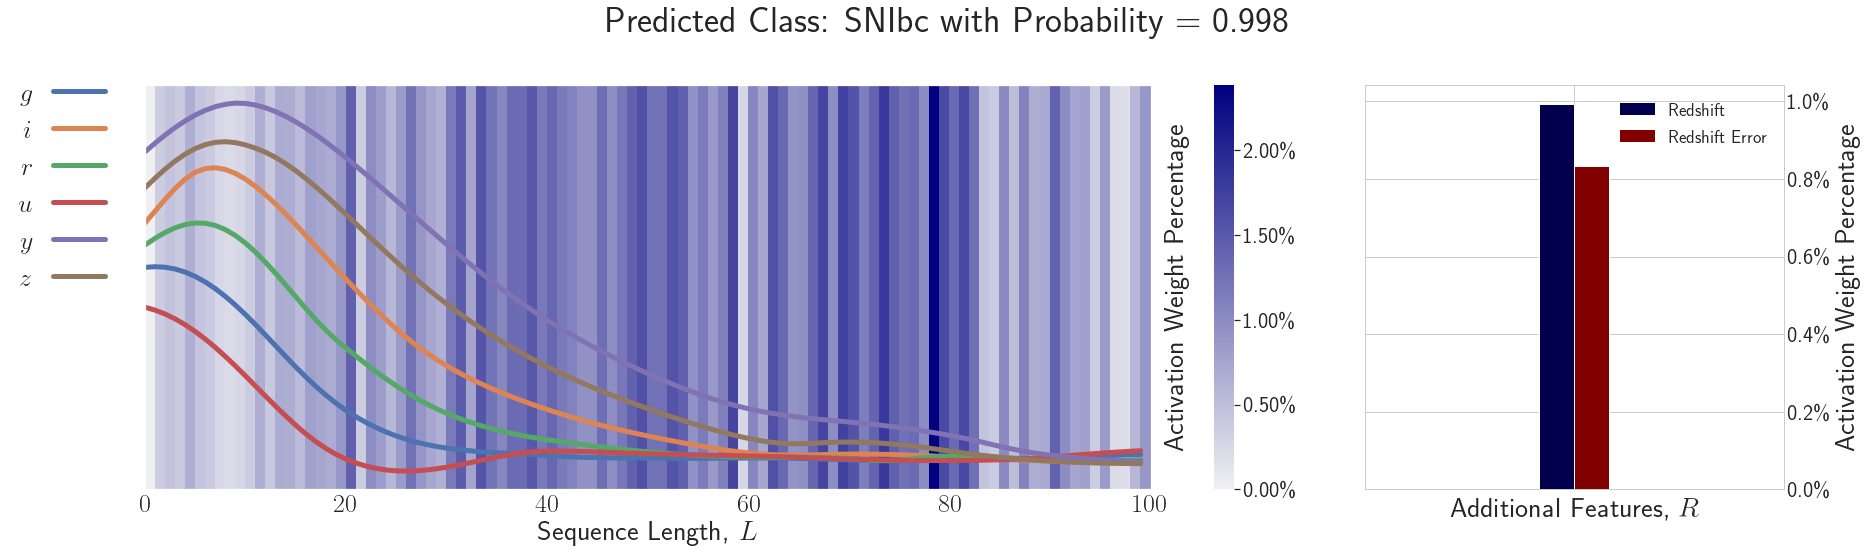

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5560833
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.77800244
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41994387
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.44303077
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.51112384
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.42691734
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7173719
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7487015
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7156603
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.46372217
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.26417834
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Pr

<Figure size 1440x216 with 0 Axes>

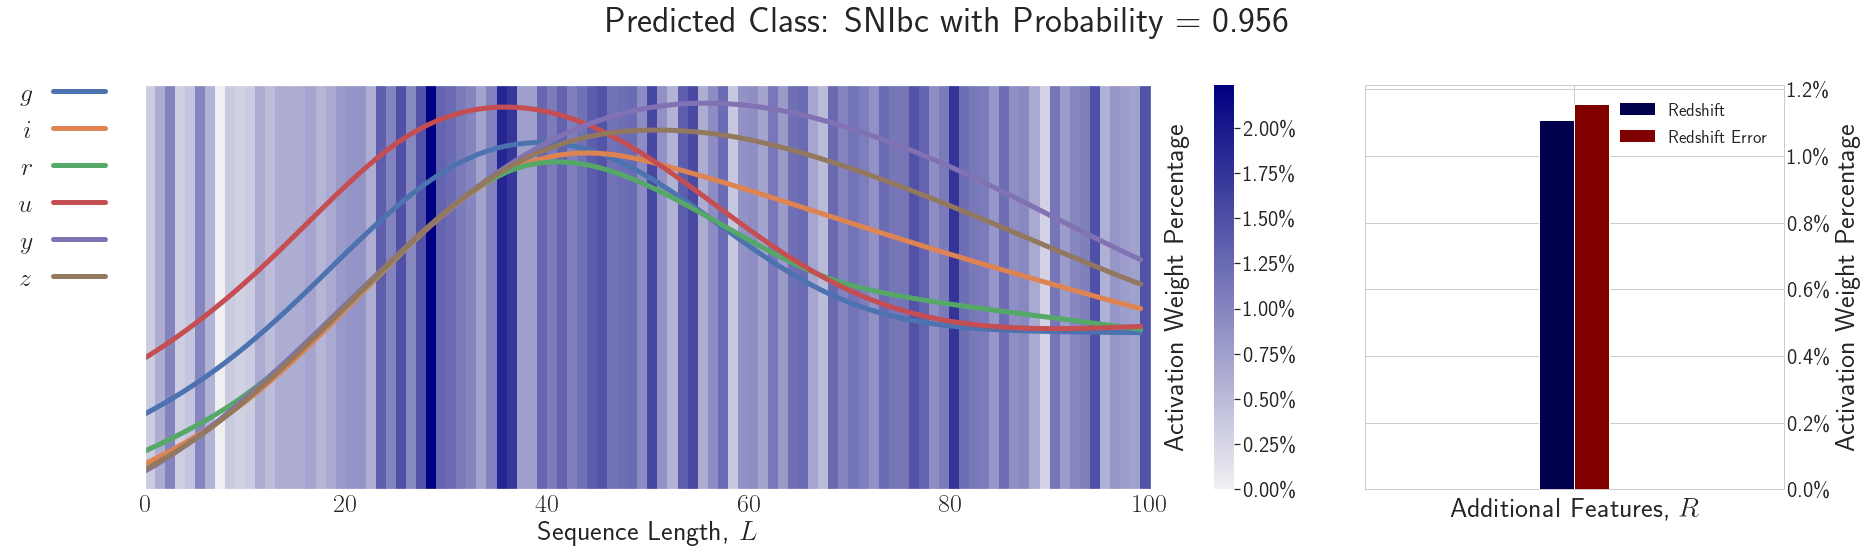

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.30464318
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.58851993
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.97483146
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003204630222172 0.000000000000000
MAX L: 0.018972263 90
SUM L: 0.9967955
SUM z: 0.0032046302
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

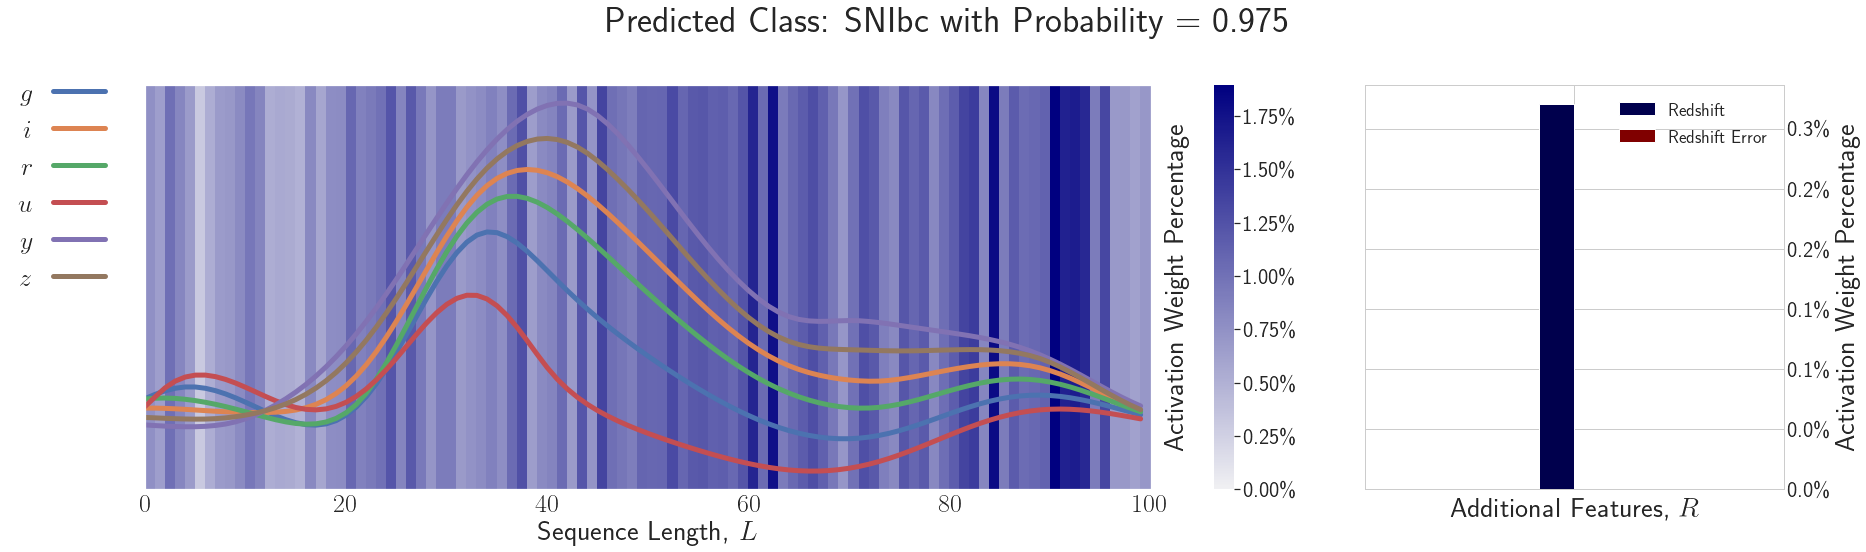

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.65442353
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40560845
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9802776
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003406252944842 0.000221775611863
MAX L: 0.021505175 72
SUM L: 0.99637204
SUM z: 0.0036280286
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

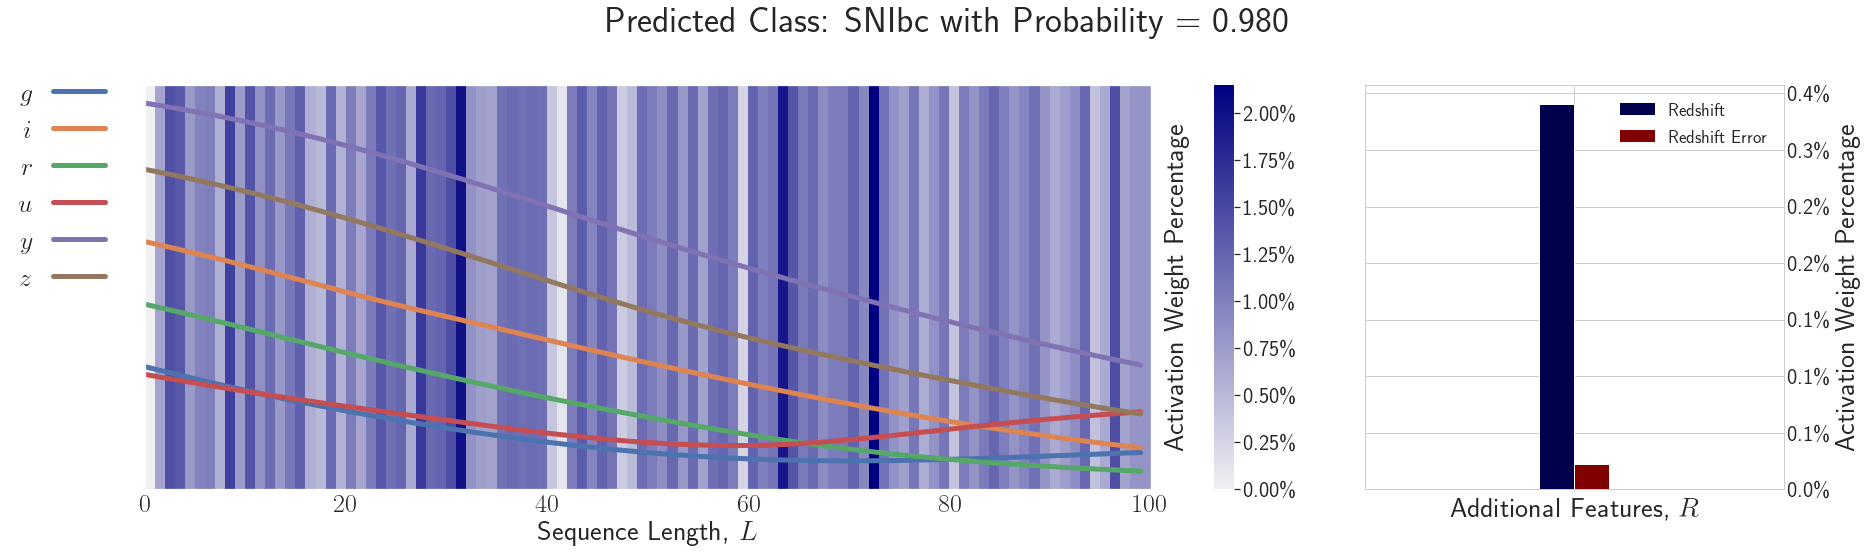

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6404426
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4942977
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8124996
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.94759953
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000474489788758 0.000000000000000
MAX L: 0.015023378 34
SUM L: 0.99952555
SUM z: 0.0004744898
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

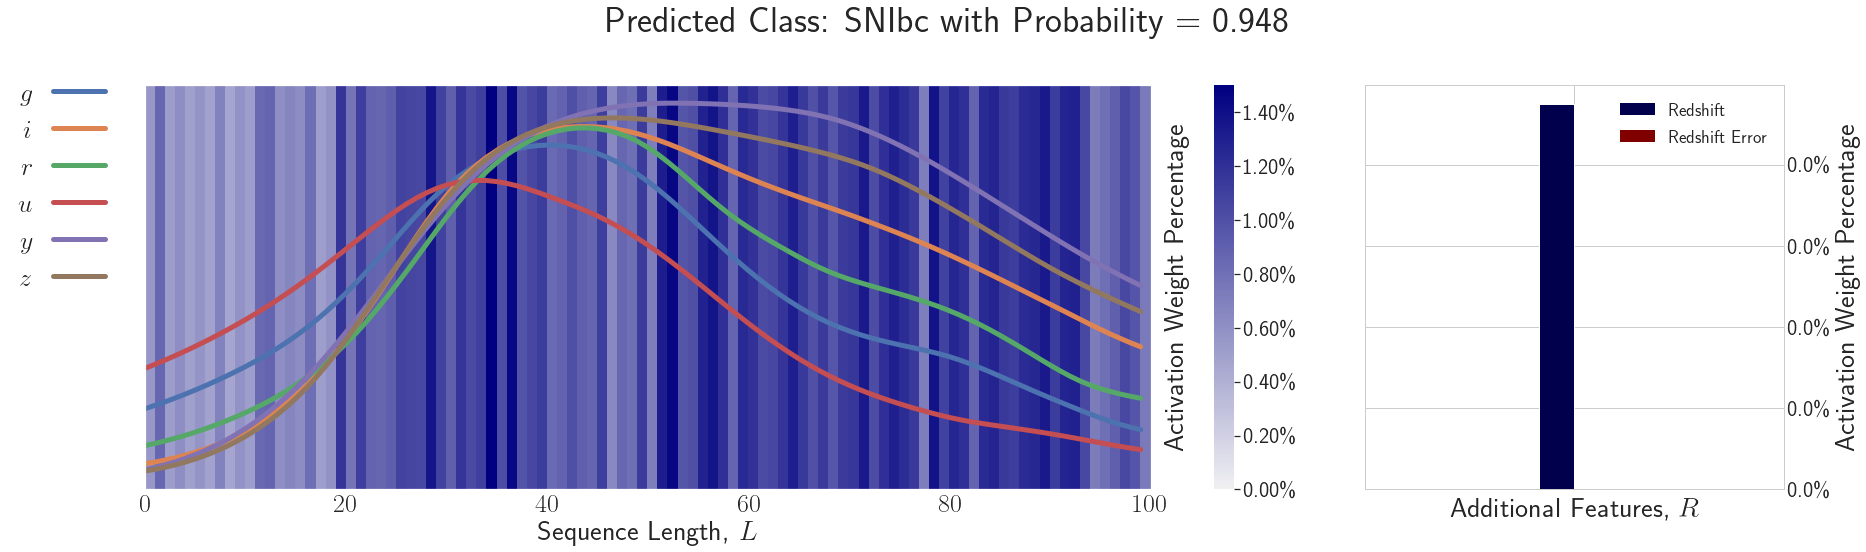

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.46110478
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.19667314
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.71513295
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40440023
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48996285
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7402844
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.45785856
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6695392
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.61572564
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.31861788
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.43534303
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class

<Figure size 1440x216 with 0 Axes>

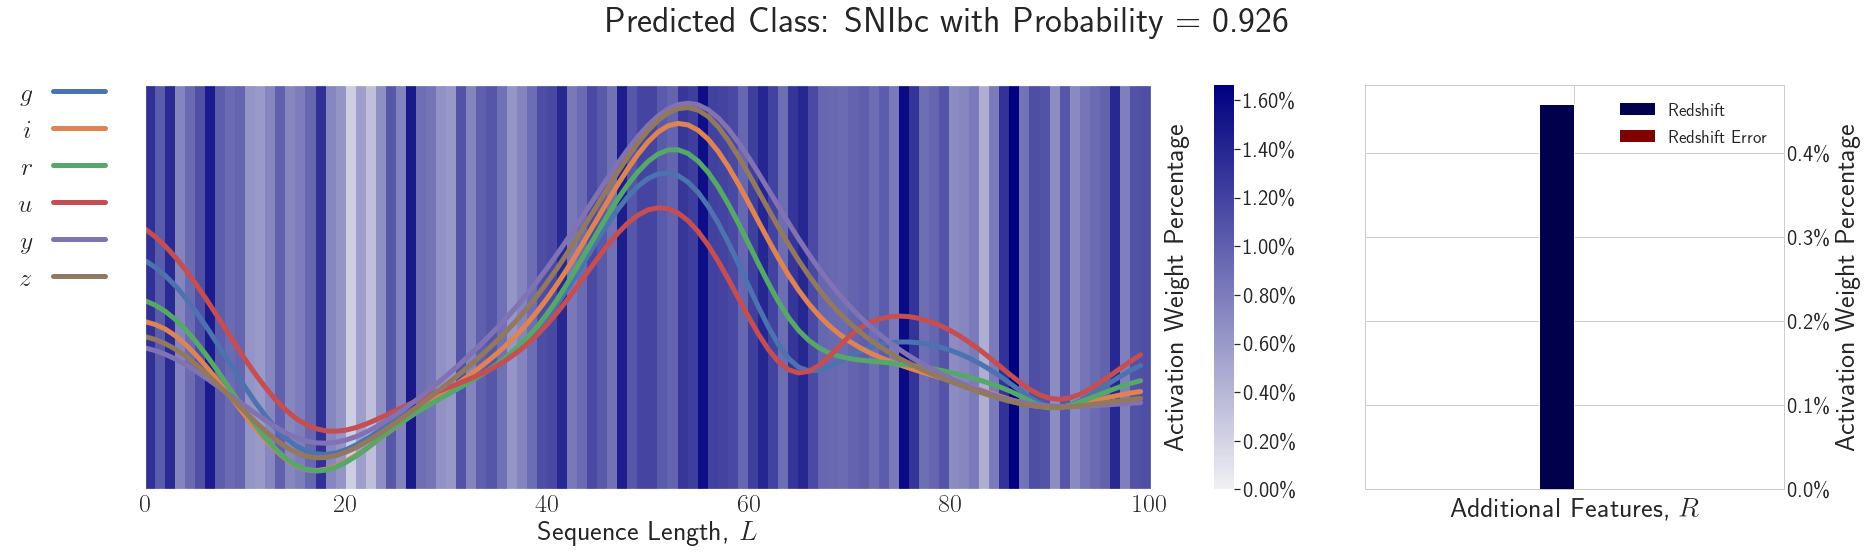

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.79292035
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.67872095
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.36696744
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5090819
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.66984284
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.65396315
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8831285
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7257987
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.65107733
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.38181344
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5603501
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.

<Figure size 1440x216 with 0 Axes>

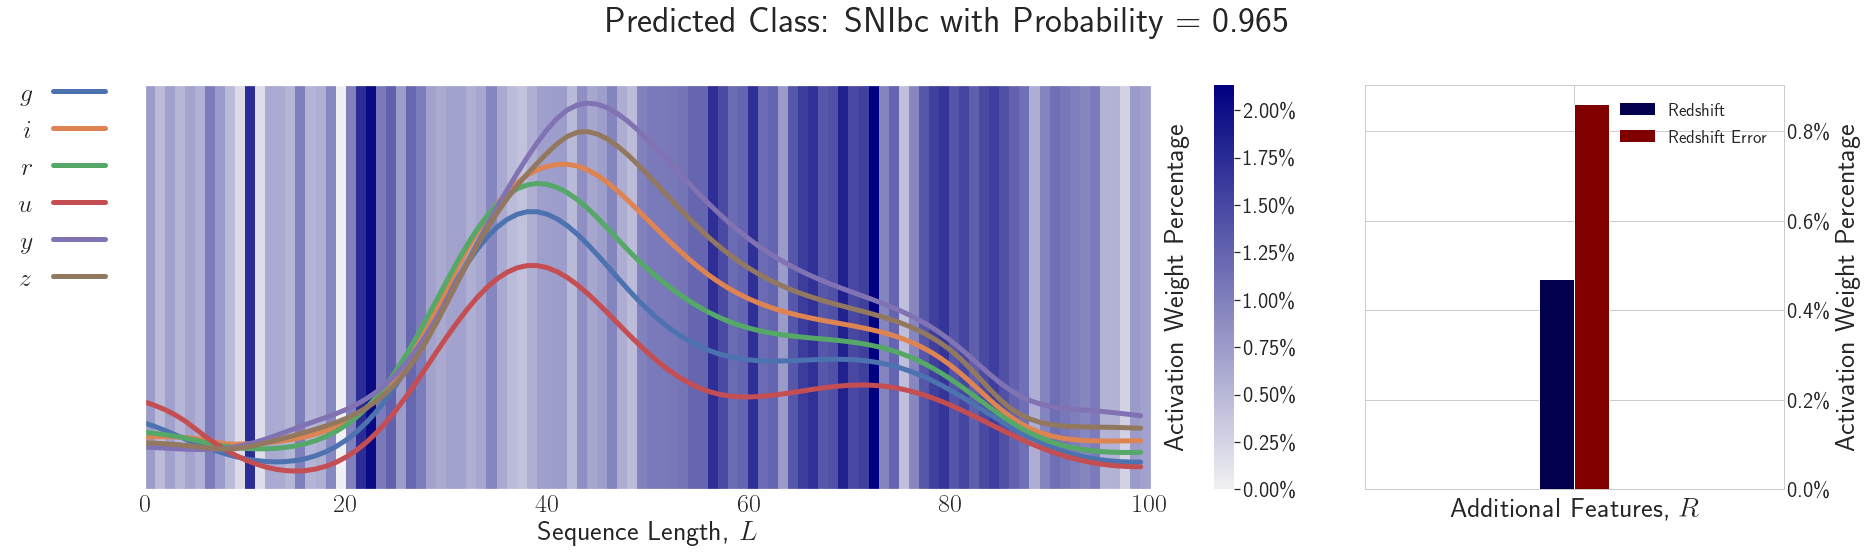

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7484654
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.29555503
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.38244733
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40767136
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.36677495
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8332357
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7463019
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.99507636
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.005085944198072 0.001808838103898
MAX L: 0.02368489 79
SUM L: 0.9931053
SUM z: 0.006894782
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

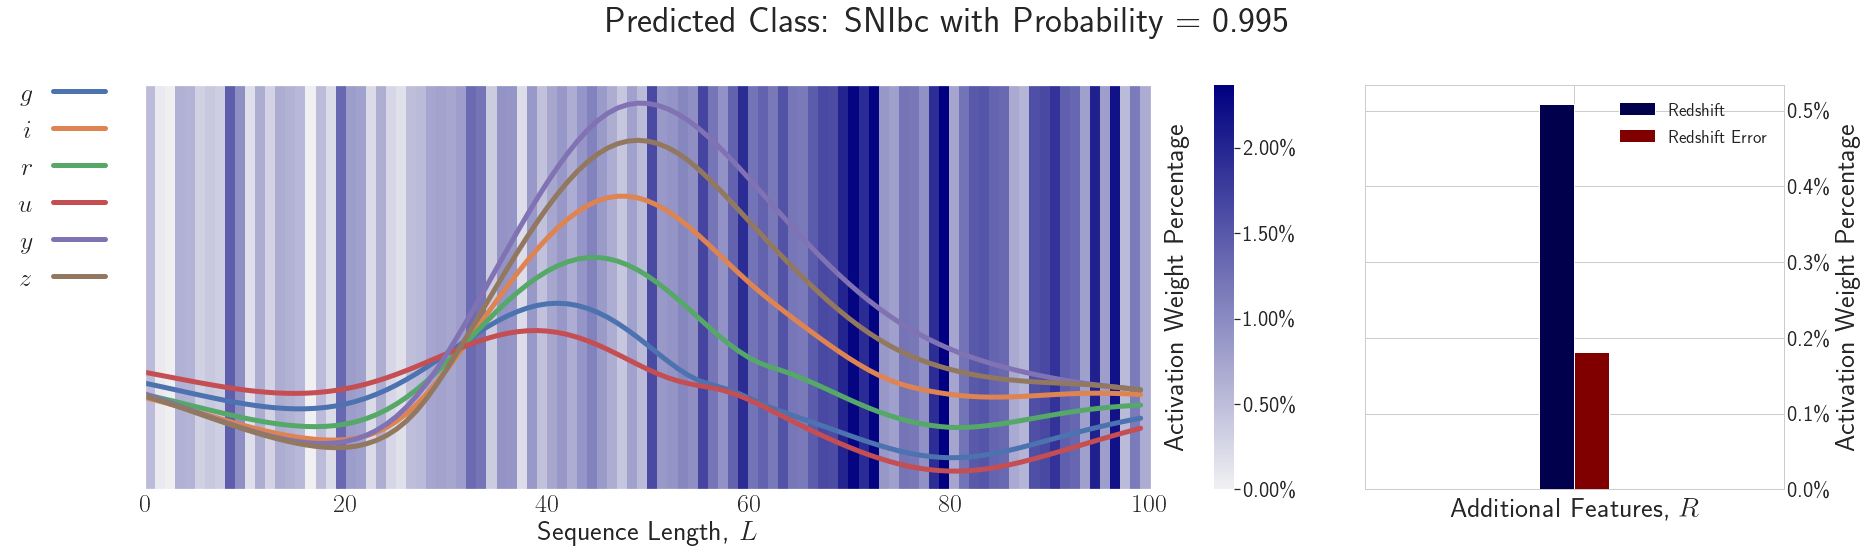

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.306811
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.91227347
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.004937718622386 0.004146316554397
MAX L: 0.027996046 74
SUM L: 0.99091595
SUM z: 0.009084035
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

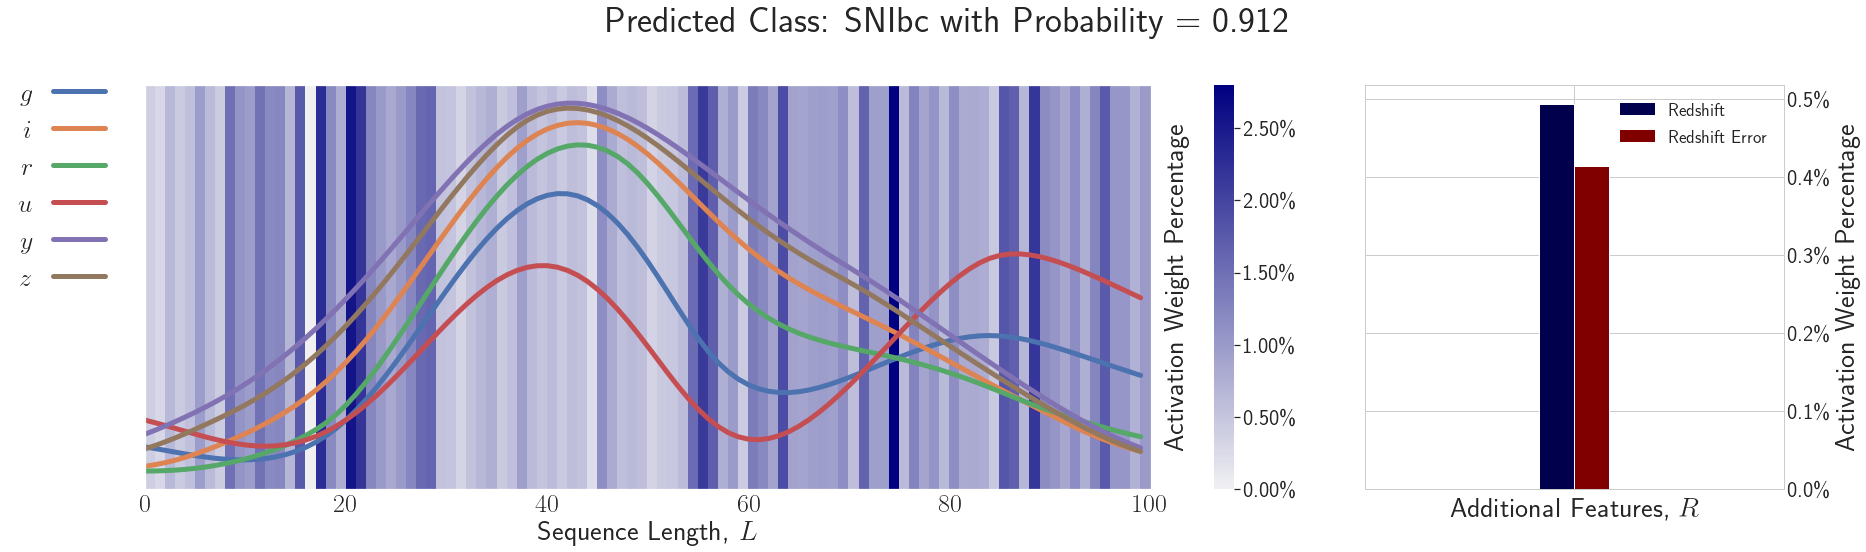

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4202376
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.46700224
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50862867
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3994543
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.84567535
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.67096466
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.53173494
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.52582186
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.44168454
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6036273
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9150306
[1.0000002]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.0088

<Figure size 1440x216 with 0 Axes>

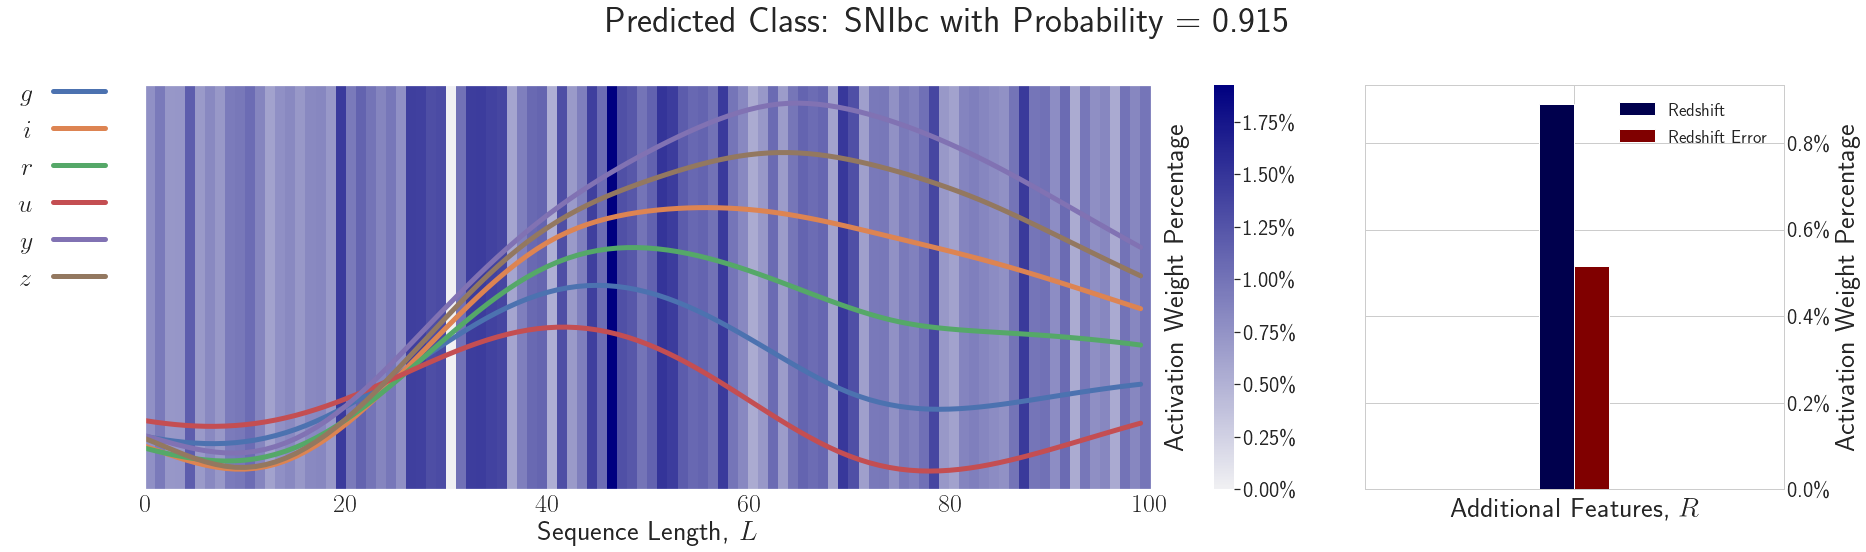

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.85595125
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7500864
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.37397313
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7022997
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7823956
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5966871
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.79522103
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.89115566
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5090272
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6429128
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.32870036
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probabi

<Figure size 1440x216 with 0 Axes>

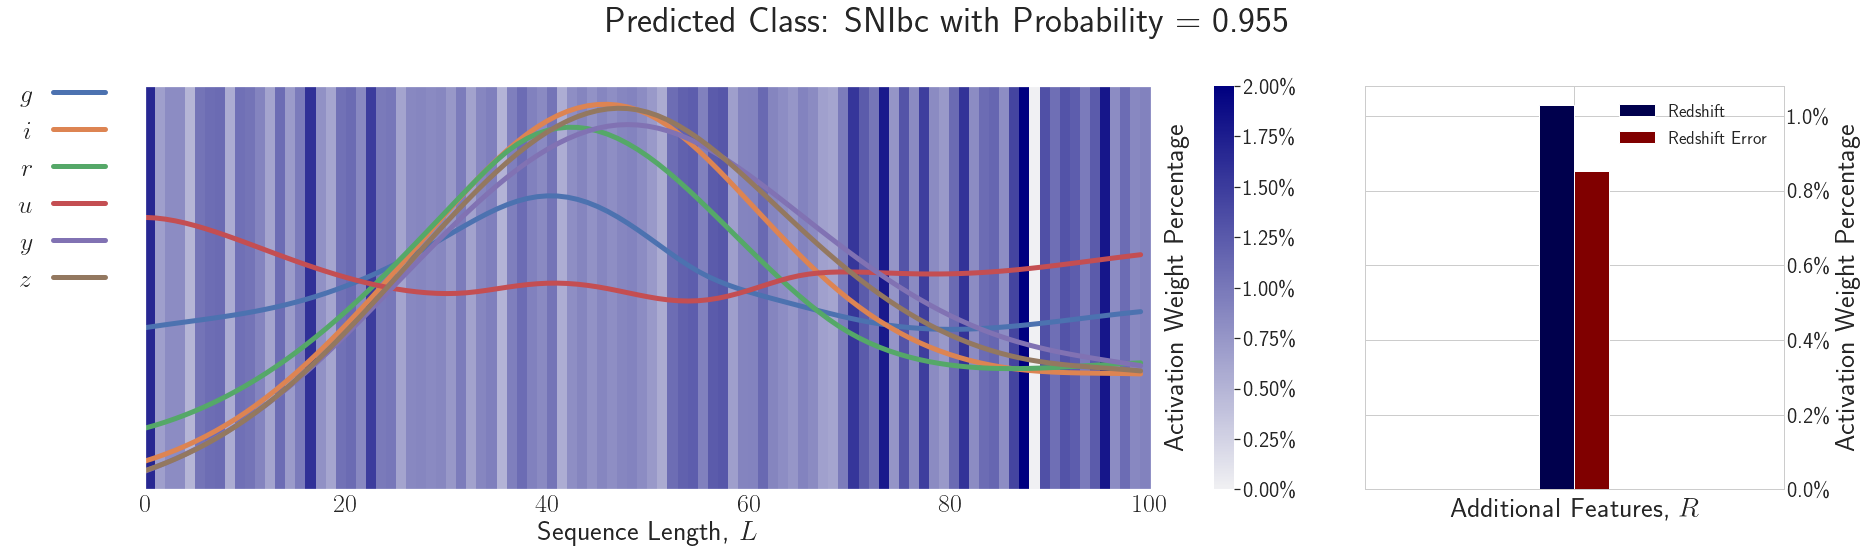

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5378468
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.85914445
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.77157974
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5194641
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4265862
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.60081714
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.46765998
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4810102
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6812493
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.64020634
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7887556
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probab

<Figure size 1440x216 with 0 Axes>

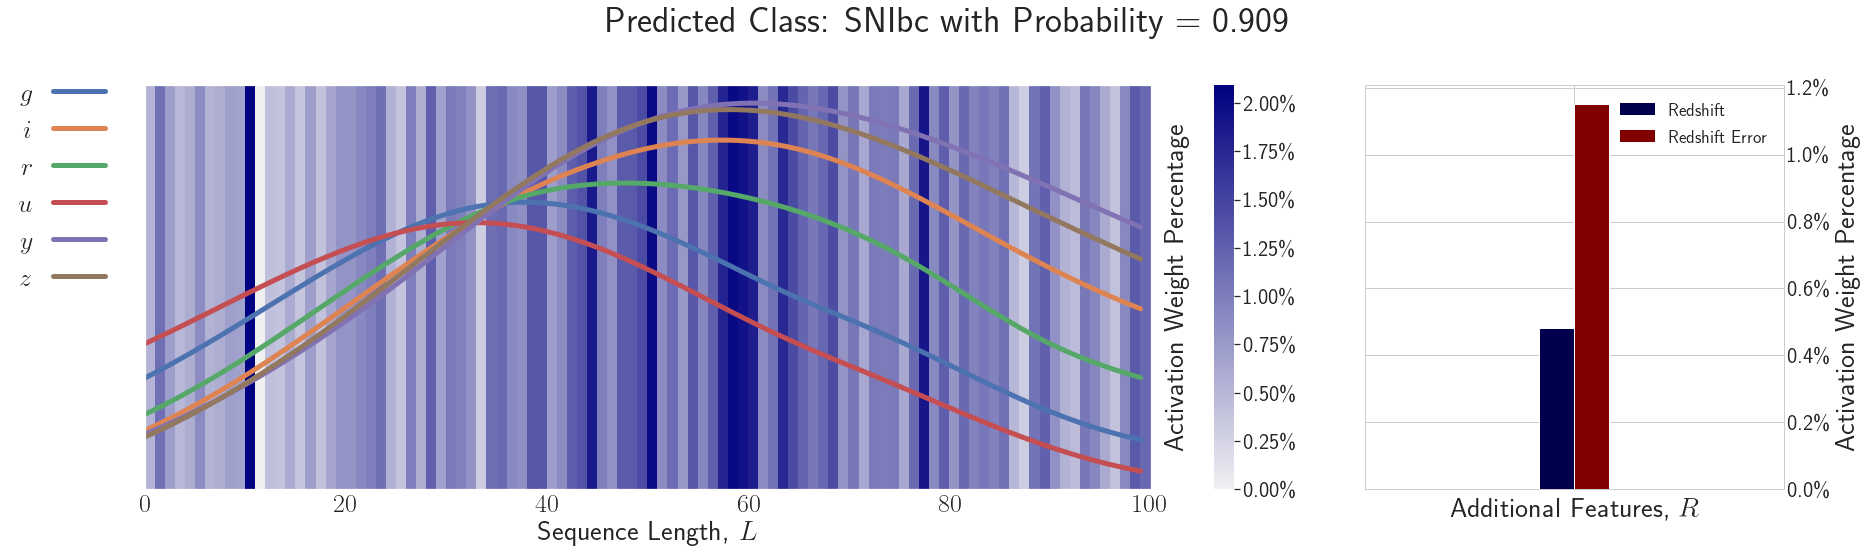

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.57969326
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.41857326
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.61779207
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.57668984
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7267805
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5156369
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.724493
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9287629
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.001243472332135 0.015917623415589
MAX L: 0.017644353 76
SUM L: 0.98283905
SUM z: 0.017161096
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

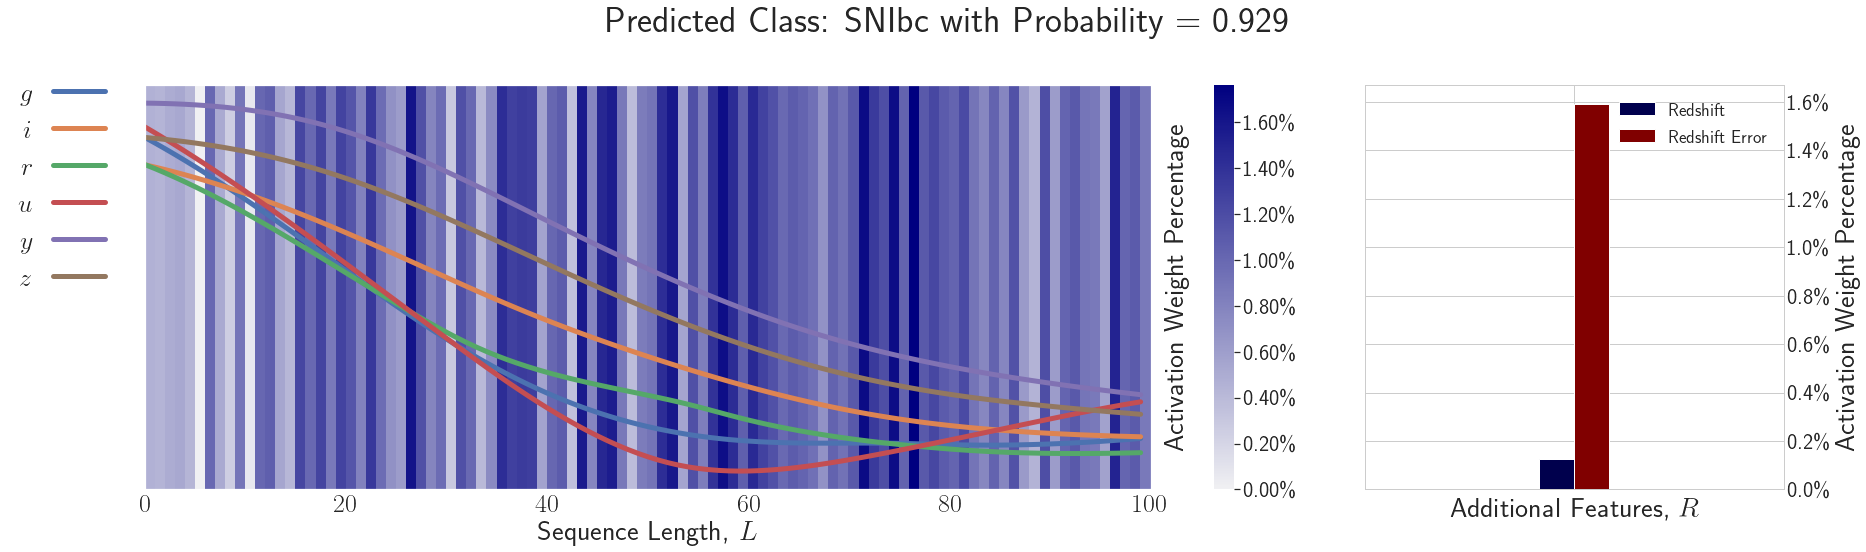

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5715363
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.37097648
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50584
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.73918104
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.847566
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.26748693
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.94719553
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.004364974331111 0.008185695856810
MAX L: 0.020388715 87
SUM L: 0.9874494
SUM z: 0.012550671
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

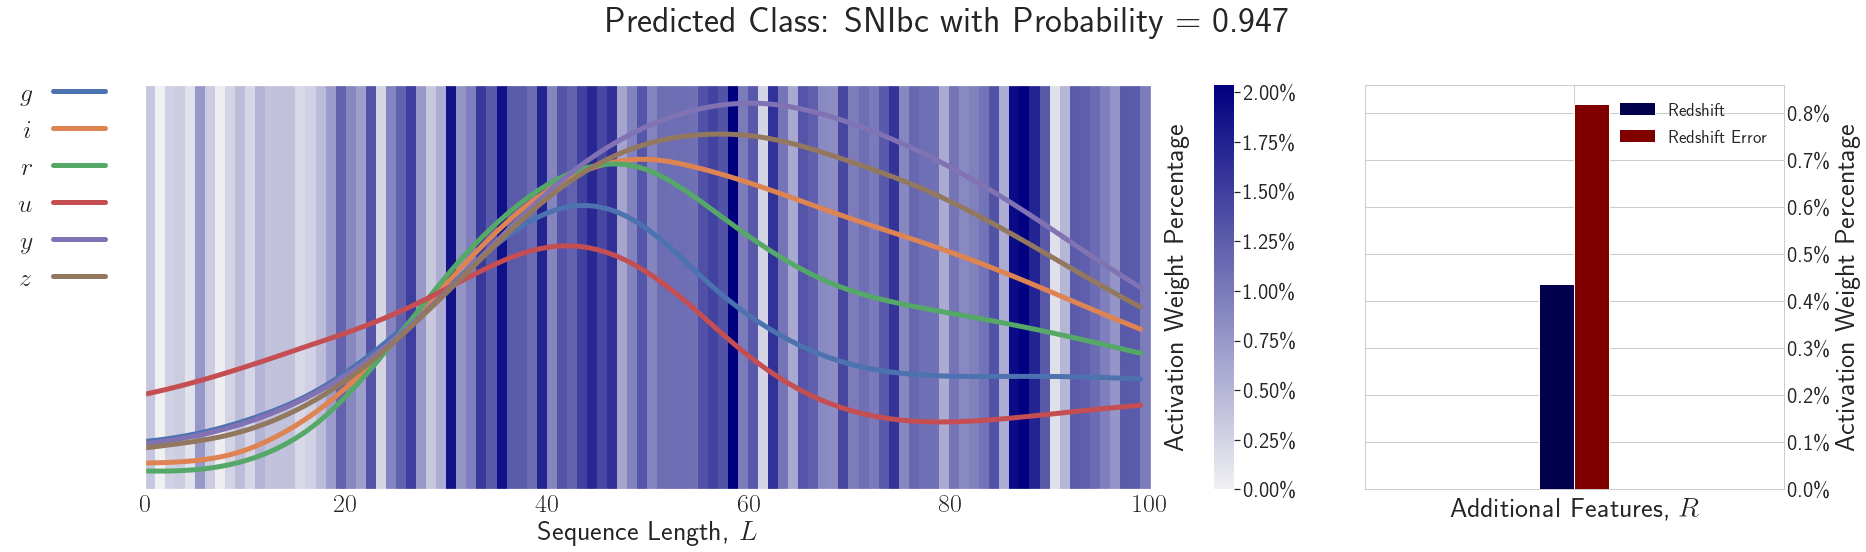

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.36770883
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5443726
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.81889844
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.53919756
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6097095
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.466657
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4156641
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.30759948
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.98563135
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.002291592536494
MAX L: 0.015291039 13
SUM L: 0.9977083
SUM z: 0.0022915925
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

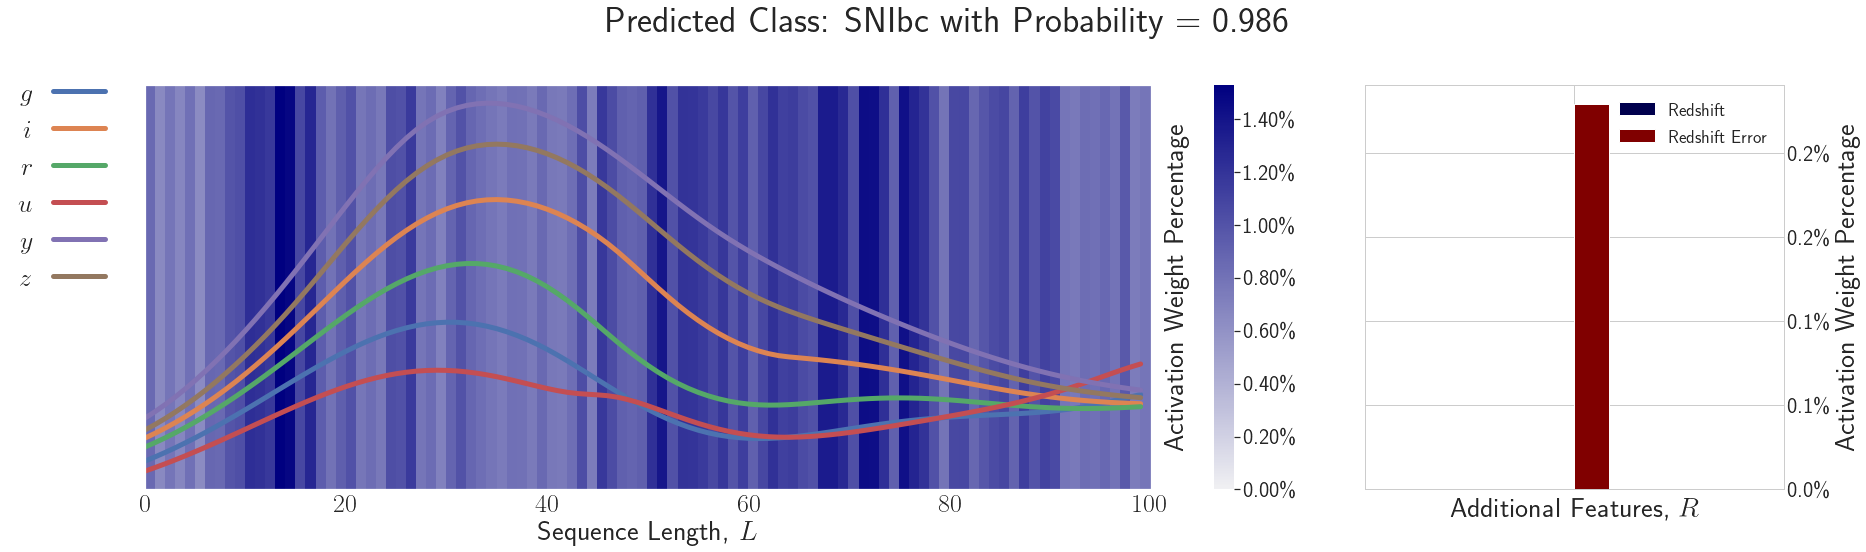

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.37641388
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7637424
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.64774644
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.49785554
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6238779
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6451673
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5547203
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.48827732
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6974347
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7643711
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.3273135
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6

<Figure size 1440x216 with 0 Axes>

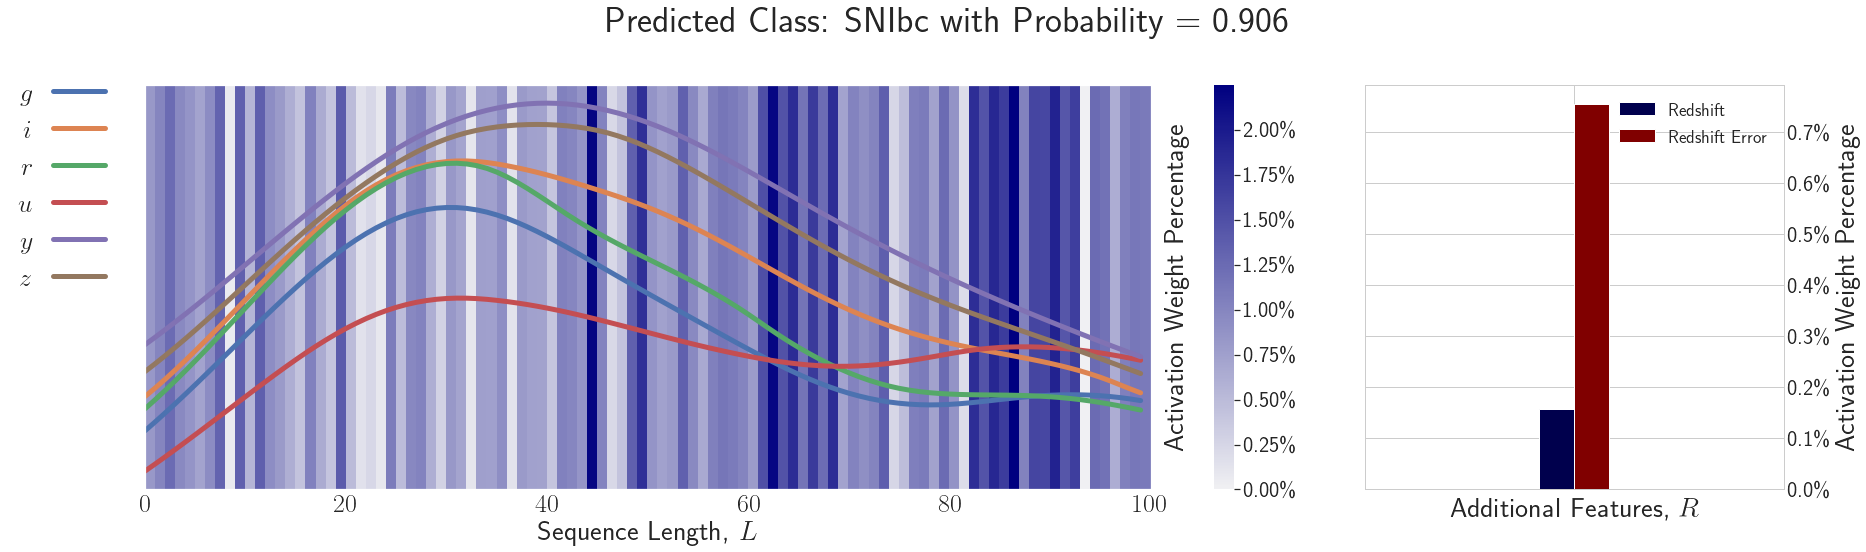

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33722696
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50614625
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9716725
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.008293473161757 0.008106935769320
MAX L: 0.021679861 42
SUM L: 0.9835998
SUM z: 0.016400408
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

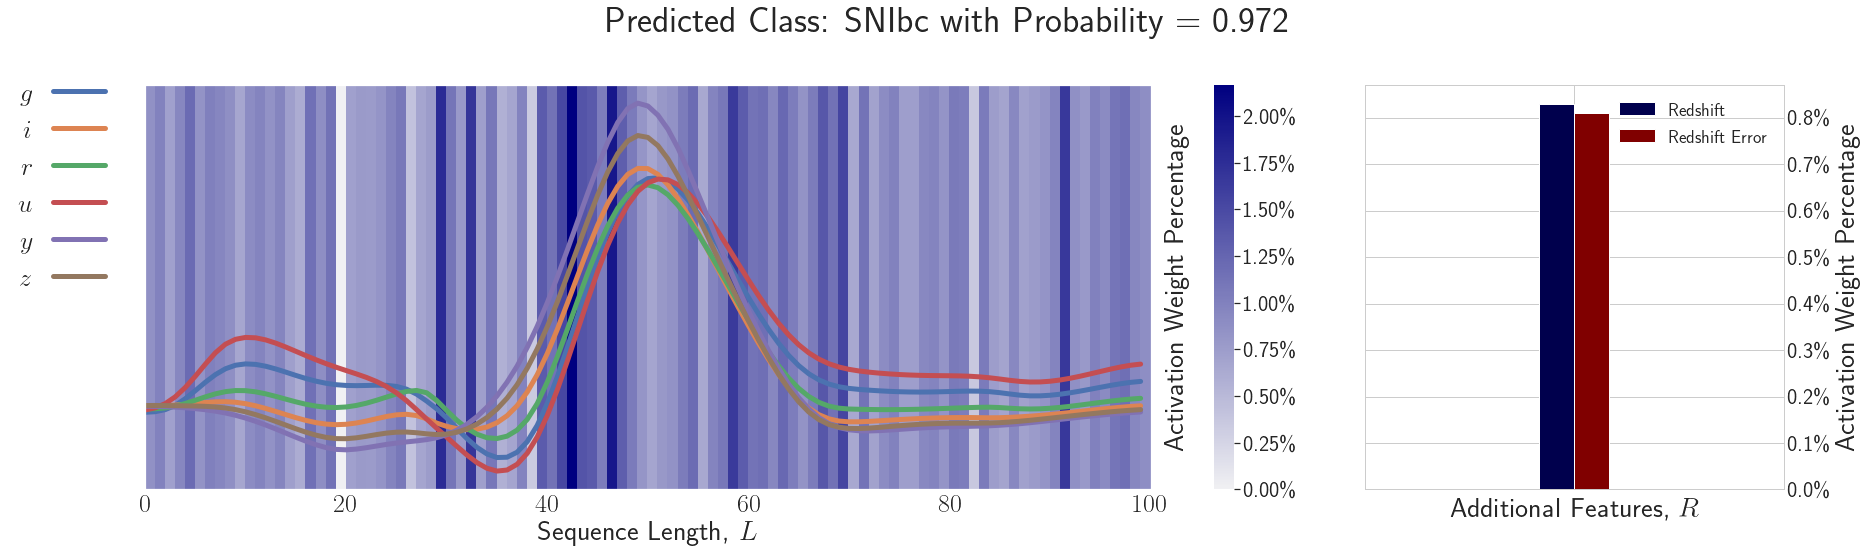

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.63446563
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.33752003
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.2828151
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40384218
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9732291
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.005802332889289 0.001185550820082
MAX L: 0.019881316 82
SUM L: 0.9930122
SUM z: 0.0069878837
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

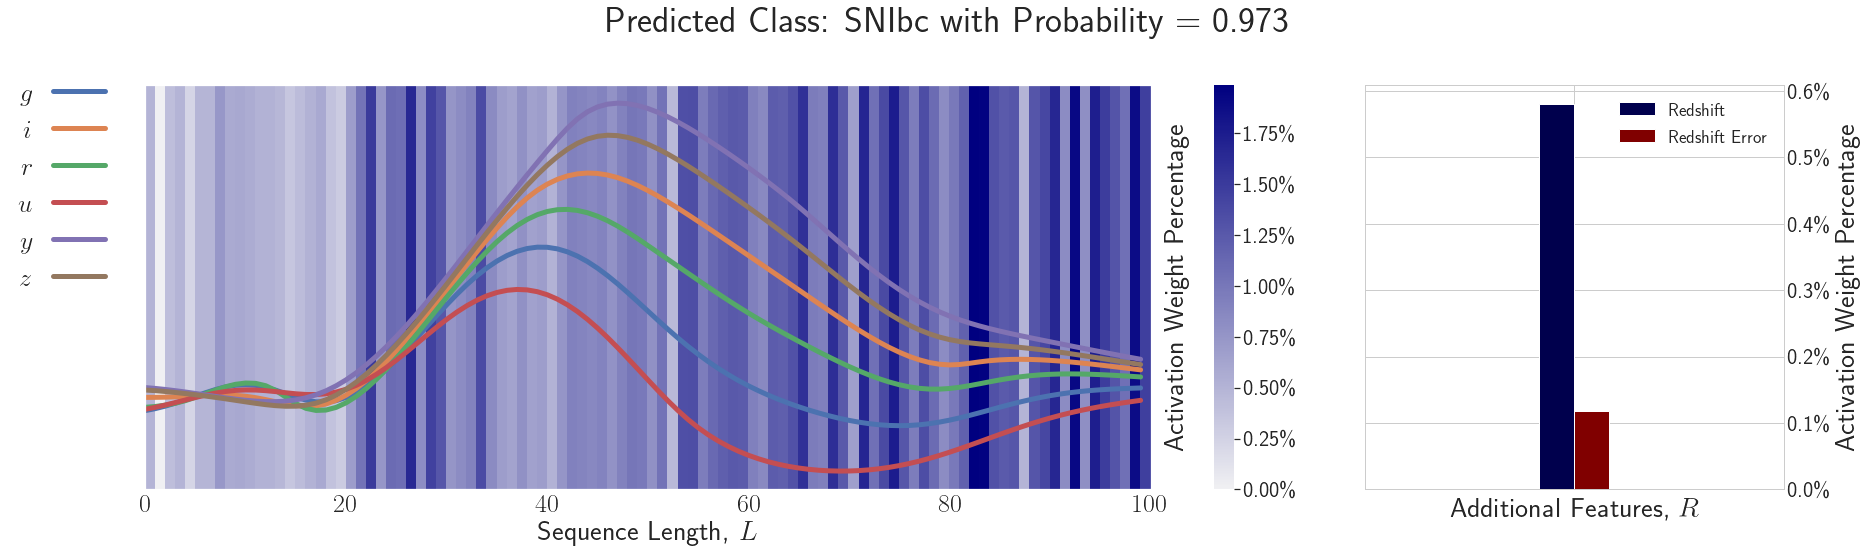

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9682326
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.005739925894886 0.001027163001709
MAX L: 0.022508923 80
SUM L: 0.99323285
SUM z: 0.006767089
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

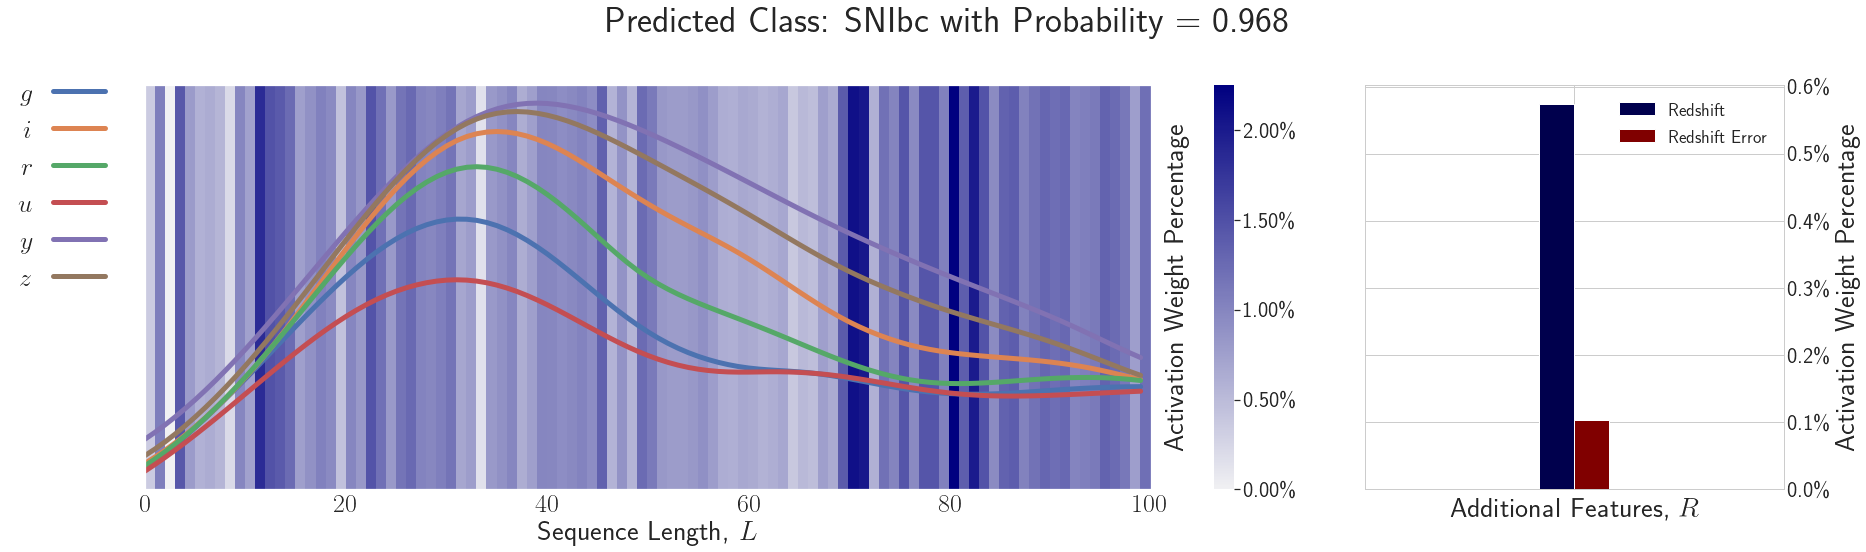

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.52712274
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50793123
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6875151
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8529495
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.46695036
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5580932
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.40703765
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5470076
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.38283777
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.43846074
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.5392383
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted 

<Figure size 1440x216 with 0 Axes>

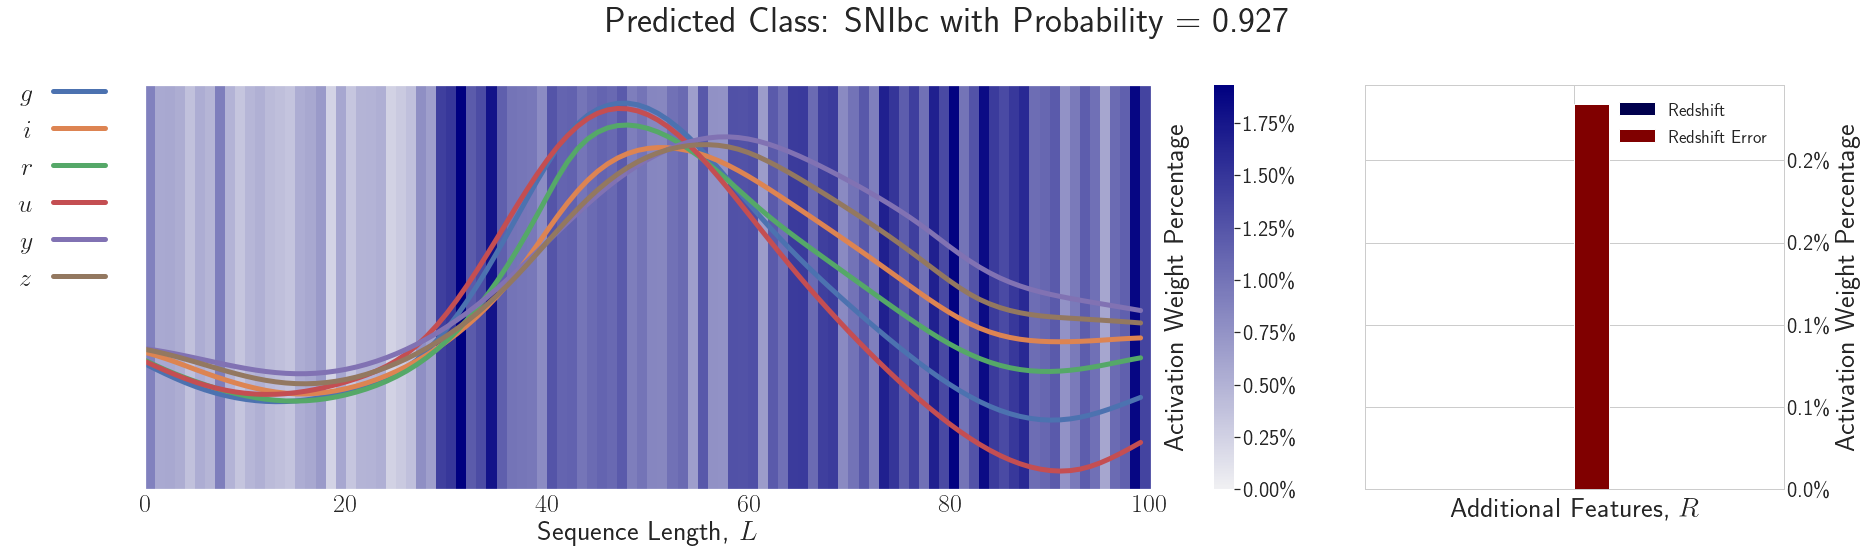

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7399883
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.66122353
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.29953784
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.71027833
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.35514992
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.59365284
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.7368926
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.4536126
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9855703
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.006313421297818 0.006278363056481
MAX L: 0.025871474 54
SUM L: 0.9874083
SUM z: 0.012591785
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

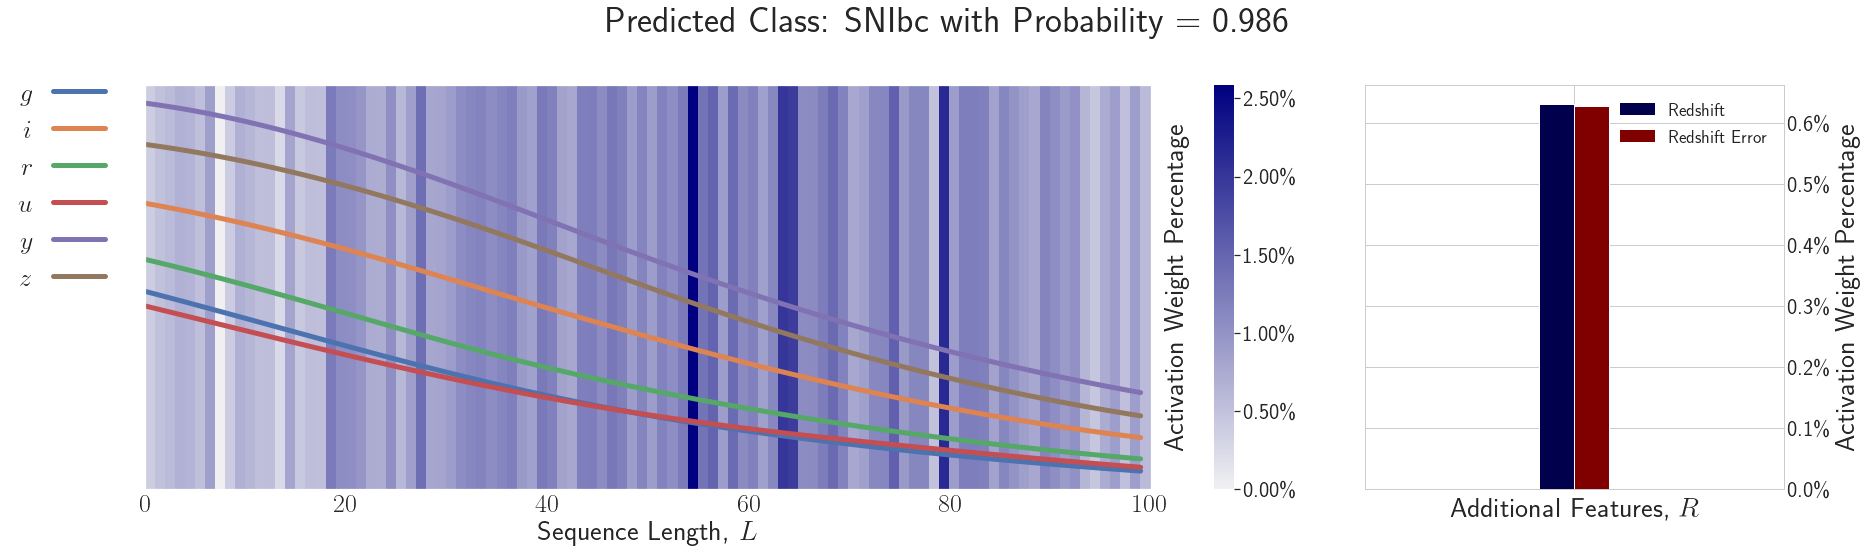

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6491208
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8139426
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.8913245
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.36327842
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.42562816
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6552037
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.44917852
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.38374087
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6174294
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9769697
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.006998640950769 0.006949658505619
MAX L: 0.020104015 83
SUM L: 0.98605174
SUM z: 0.013948299
SUM CAM: 1.0


<Figure size 1440x216 with 0 Axes>

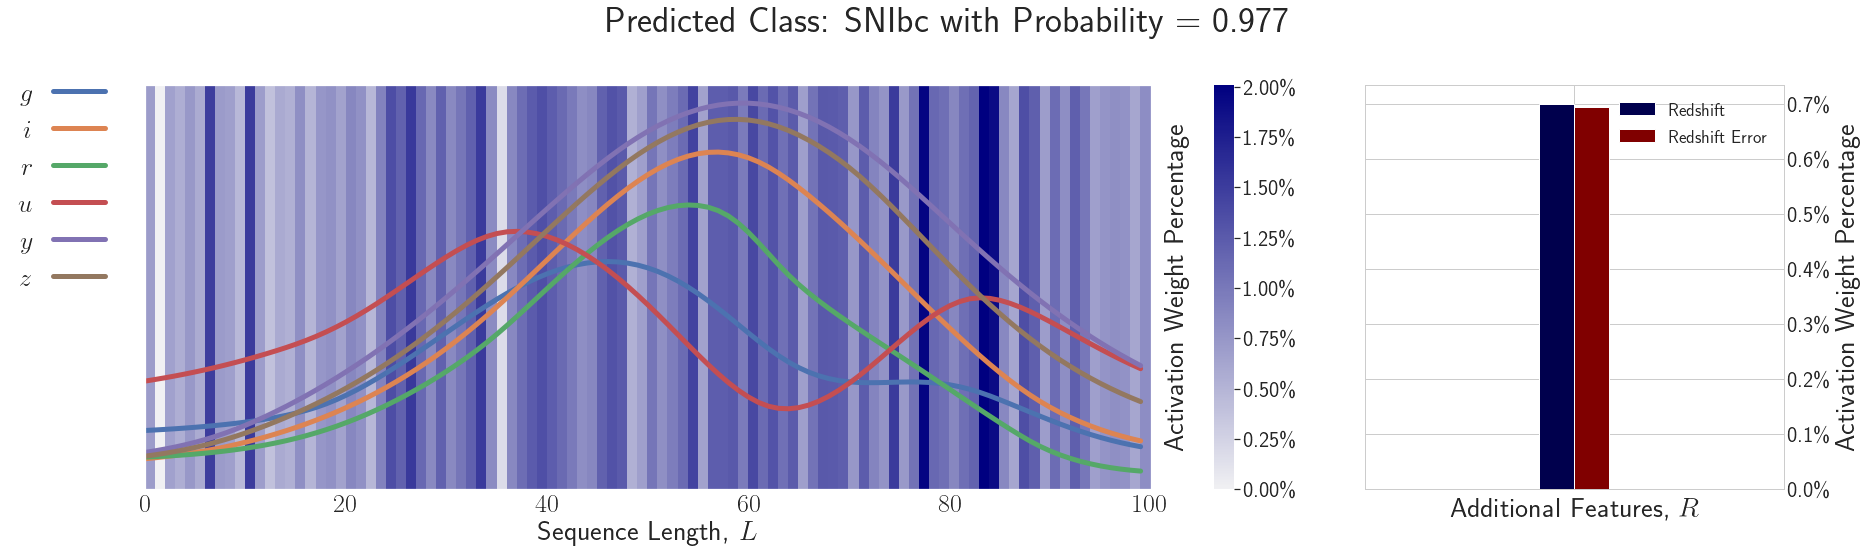

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6159482
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.50623715
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9677578
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.002330371411517 0.000549398770090
MAX L: 0.018721176 36
SUM L: 0.99712026
SUM z: 0.0028797702
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

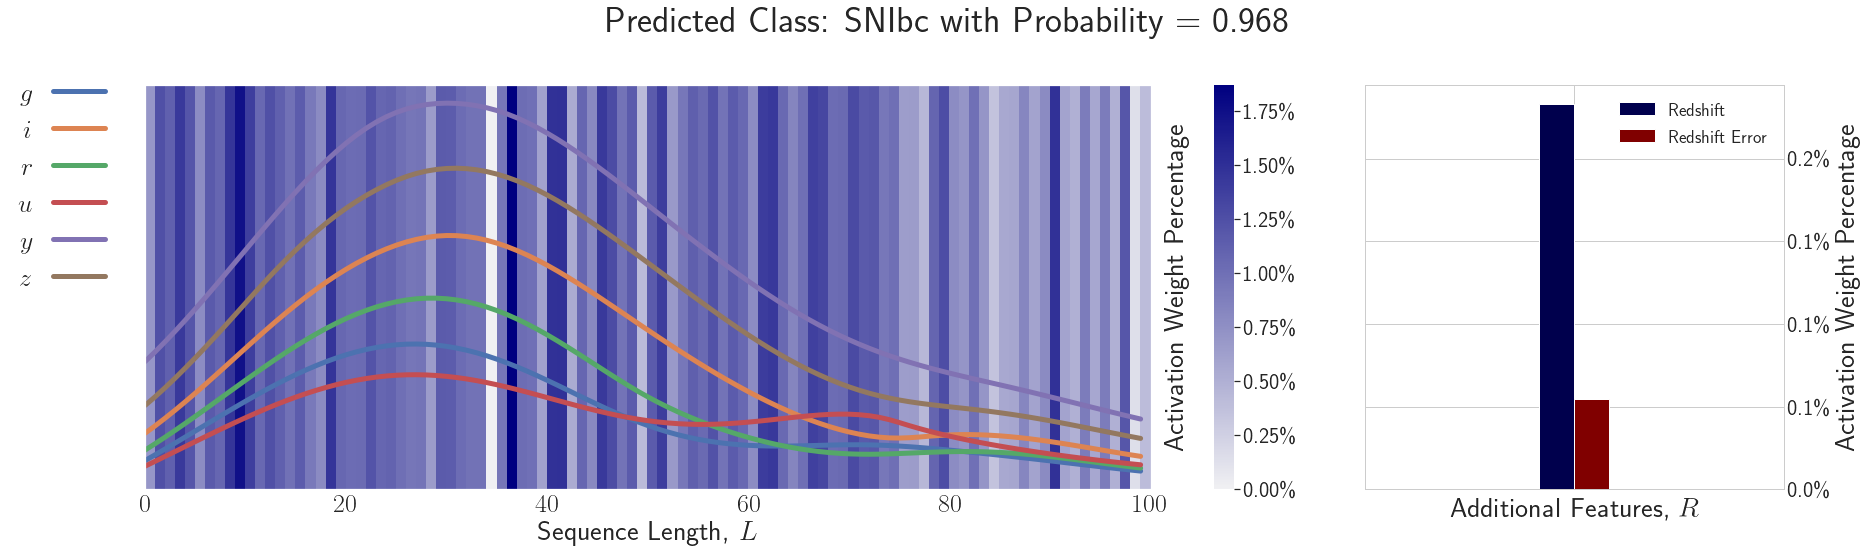

(102,)
(1, 102)
Predicted Class = 6, Probability = 0.80105954
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.6221884
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.523648
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 6, Probability = 0.9971155
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003767826594412 0.008588667958975
MAX L: 0.0196562 58
SUM L: 0.9876436
SUM z: 0.012356495
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1440x216 with 0 Axes>

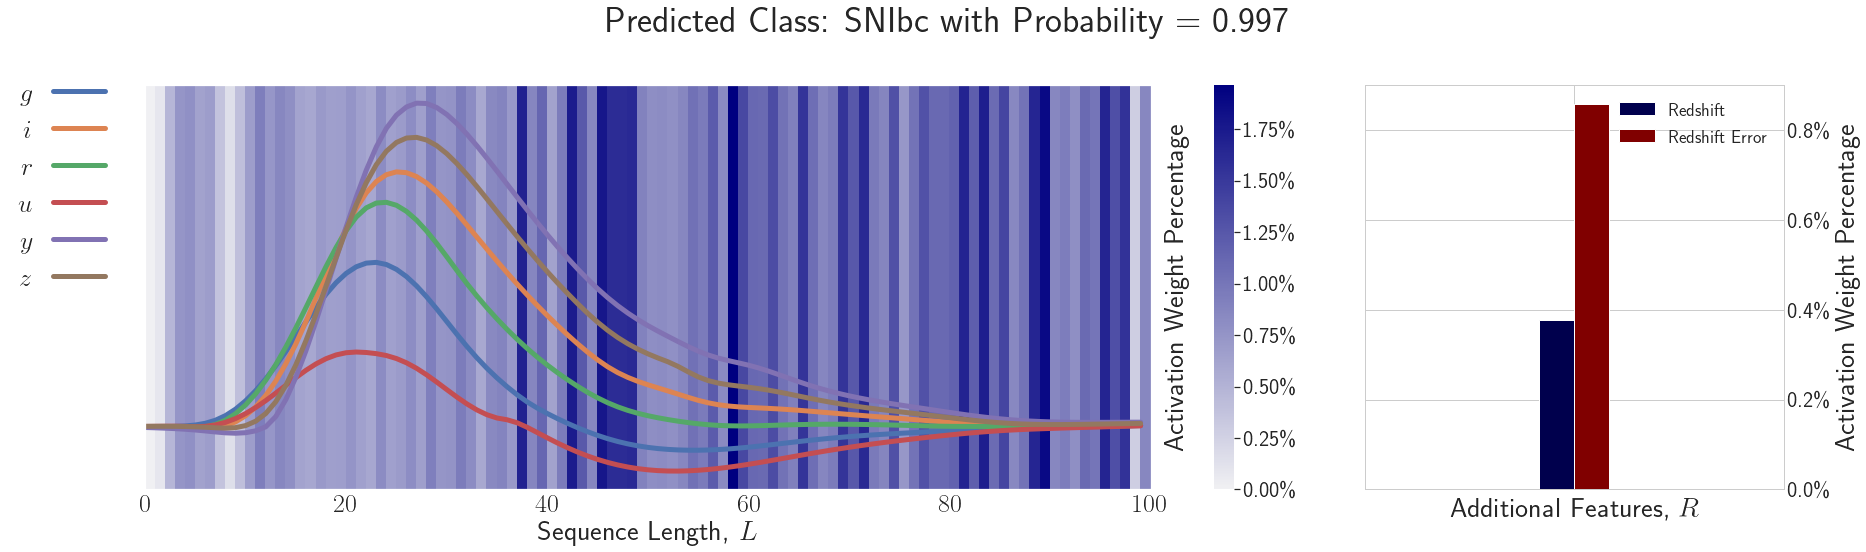

<Figure size 1440x216 with 0 Axes>

In [164]:
# Attempt to show 40 examples of SNIa
show_maps(desired_class=class_names.index("SNIbc"), num_maps=50)

# Make CAMs for all classes with x num_maps attempts
# make_cams(40)